In [6]:
!gdown -O "app/test_data/raw/0bfacc_0.mp4" "https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF"
!gdown -O "app/test_data/raw/2e57b9_0.mp4" "https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf"
!gdown -O "app/test_data/raw/08fd33_0.mp4" "https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-"
!gdown -O "app/test_data/raw/573e61_0.mp4" "https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU"
!gdown -O "app/test_data/raw/121364_0.mp4" "https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu"

Downloading...
From: https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF
To: /home/ubuntu/projects/sure-football-analysis/app/test_data/raw/0bfacc_0.mp4
100%|██████████████████████████████████████| 19.9M/19.9M [00:00<00:00, 93.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf
To: /home/ubuntu/projects/sure-football-analysis/app/test_data/raw/2e57b9_0.mp4
100%|██████████████████████████████████████| 21.1M/21.1M [00:00<00:00, 30.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-
To: /home/ubuntu/projects/sure-football-analysis/app/test_data/raw/08fd33_0.mp4
100%|██████████████████████████████████████| 19.9M/19.9M [00:00<00:00, 51.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU
To: /home/ubuntu/projects/sure-football-analysis/app/test_data/raw/573e61_0.mp4
100%|██████████████████████████████████████| 18.9M/18.9M [00:00<00:00, 47.2MB/s]
Downloading.

In [1]:
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/home/ubuntu/projects/sure-football-analysis


In [3]:
# from dotenv import load_dotenv
# load_dotenv(os.path.join(HOME, ".env"))

In [4]:
# from inference import get_model
from ultralytics import YOLO

# ROBOFLOW_API_KEY = os.environ.get("ROBOFLOW_API_KEY")
# PLAYER_DETECTION_MODEL_ID = "football-players-detection-3zvbc/12"
# PLAYER_DETECTION_MODEL = get_model(PLAYER_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)
PLAYER_DETECTION_MODEL = YOLO("app/models/yolo11_football_v2/weights/best.pt")

In [5]:
import torch
from transformers import AutoProcessor, SiglipVisionModel

SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EMBEDDINGS_MODEL = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
EMBEDDINGS_PROCESSOR = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)

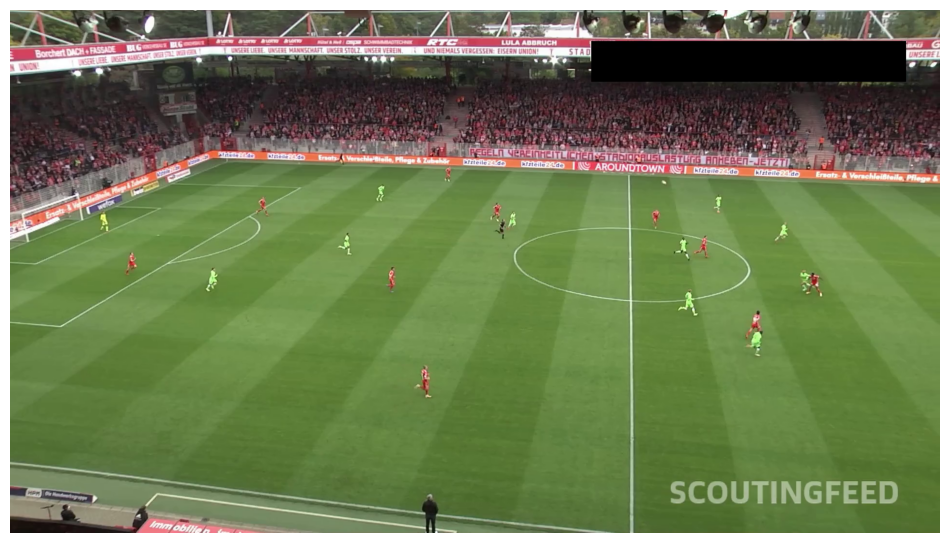

In [6]:
import supervision as sv

SOURCE_VIDEO_PATH = "app/test_data/raw/121364_0.mp4"

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

sv.plot_image(frame)


0: 1280x1280 1 ball, 2 goalkeepers, 20 players, 2 referees, 65.5ms
Speed: 11.2ms preprocess, 65.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


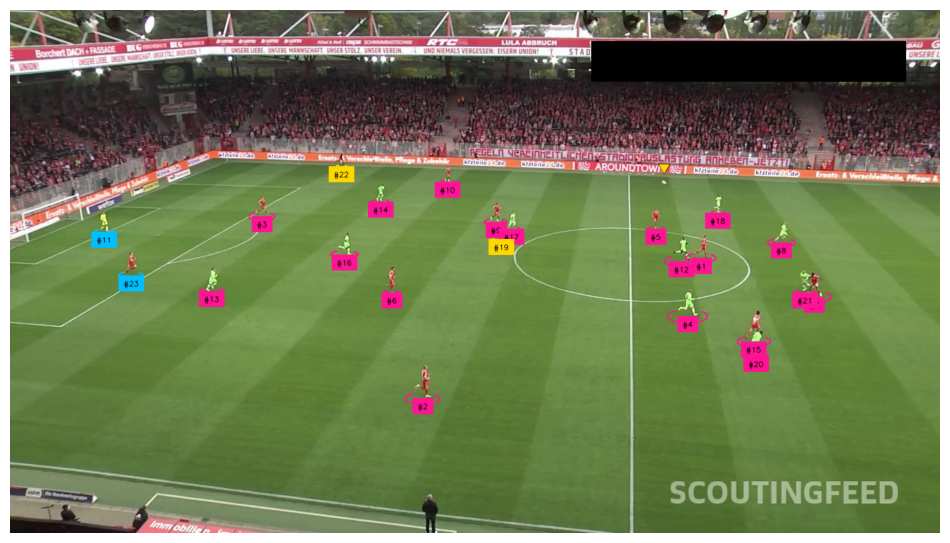

In [7]:
BALL_ID = 0

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

# result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3)[0]
# detections = sv.Detections.from_inference(result)
detections = sv.Detections.from_ultralytics(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections.class_id -= 1
all_detections = tracker.update_with_detections(detections=all_detections)

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

In [9]:
from tqdm import tqdm

PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    # result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3)[0]
    # detections = sv.Detections.from_inference(result)
    detections = sv.Detections.from_ultralytics(result)
    detections = detections.with_nms(threshold=0.5, class_agnostic=True)
    detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

collecting crops: 0it [00:00, ?it/s]


0: 1280x1280 1 ball, 2 goalkeepers, 20 players, 2 referees, 65.8ms
Speed: 10.7ms preprocess, 65.8ms inference, 105.2ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 1it [00:00,  1.04it/s]


0: 1280x1280 1 goalkeeper, 20 players, 2 referees, 65.8ms
Speed: 11.7ms preprocess, 65.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 2it [00:01,  2.00it/s]


0: 1280x1280 1 goalkeeper, 21 players, 2 referees, 65.7ms
Speed: 12.3ms preprocess, 65.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 3it [00:01,  2.86it/s]


0: 1280x1280 20 players, 2 referees, 66.1ms
Speed: 14.0ms preprocess, 66.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 4it [00:01,  3.61it/s]


0: 1280x1280 1 ball, 20 players, 2 referees, 66.1ms
Speed: 7.6ms preprocess, 66.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 5it [00:01,  4.18it/s]


0: 1280x1280 1 ball, 20 players, 2 referees, 65.9ms
Speed: 11.0ms preprocess, 65.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 6it [00:01,  4.68it/s]


0: 1280x1280 20 players, 2 referees, 66.2ms
Speed: 13.0ms preprocess, 66.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 7it [00:01,  4.97it/s]


0: 1280x1280 1 ball, 19 players, 2 referees, 66.0ms
Speed: 11.2ms preprocess, 66.0ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 8it [00:02,  5.30it/s]


0: 1280x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 66.4ms
Speed: 7.8ms preprocess, 66.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 9it [00:02,  5.50it/s]


0: 1280x1280 1 ball, 21 players, 2 referees, 65.8ms
Speed: 8.0ms preprocess, 65.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 10it [00:02,  5.55it/s]


0: 1280x1280 1 ball, 22 players, 2 referees, 66.0ms
Speed: 11.2ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 11it [00:02,  5.65it/s]


0: 1280x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 66.1ms
Speed: 8.0ms preprocess, 66.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 12it [00:02,  5.70it/s]


0: 1280x1280 1 goalkeeper, 21 players, 2 referees, 66.1ms
Speed: 10.4ms preprocess, 66.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 13it [00:02,  5.84it/s]


0: 1280x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 66.2ms
Speed: 7.7ms preprocess, 66.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 14it [00:03,  5.84it/s]


0: 1280x1280 1 goalkeeper, 21 players, 2 referees, 65.9ms
Speed: 12.1ms preprocess, 65.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 15it [00:03,  5.91it/s]


0: 1280x1280 21 players, 2 referees, 66.2ms
Speed: 8.3ms preprocess, 66.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 16it [00:03,  5.88it/s]


0: 1280x1280 20 players, 3 referees, 65.7ms
Speed: 11.1ms preprocess, 65.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 17it [00:03,  5.94it/s]


0: 1280x1280 22 players, 1 referee, 65.9ms
Speed: 11.5ms preprocess, 65.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 18it [00:03,  5.94it/s]


0: 1280x1280 22 players, 2 referees, 65.8ms
Speed: 8.0ms preprocess, 65.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 19it [00:04,  5.90it/s]


0: 1280x1280 23 players, 2 referees, 66.1ms
Speed: 11.4ms preprocess, 66.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 20it [00:04,  5.95it/s]


0: 1280x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 66.1ms
Speed: 8.0ms preprocess, 66.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 21it [00:04,  5.89it/s]


0: 1280x1280 1 goalkeeper, 21 players, 2 referees, 66.1ms
Speed: 10.4ms preprocess, 66.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 22it [00:04,  5.99it/s]


0: 1280x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 66.4ms
Speed: 8.1ms preprocess, 66.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 23it [00:04,  5.90it/s]


0: 1280x1280 1 goalkeeper, 22 players, 1 referee, 66.3ms
Speed: 11.0ms preprocess, 66.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 24it [00:04,  5.97it/s]


0: 1280x1280 1 goalkeeper, 22 players, 2 referees, 66.4ms
Speed: 8.2ms preprocess, 66.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 25it [00:05,  4.91it/s]


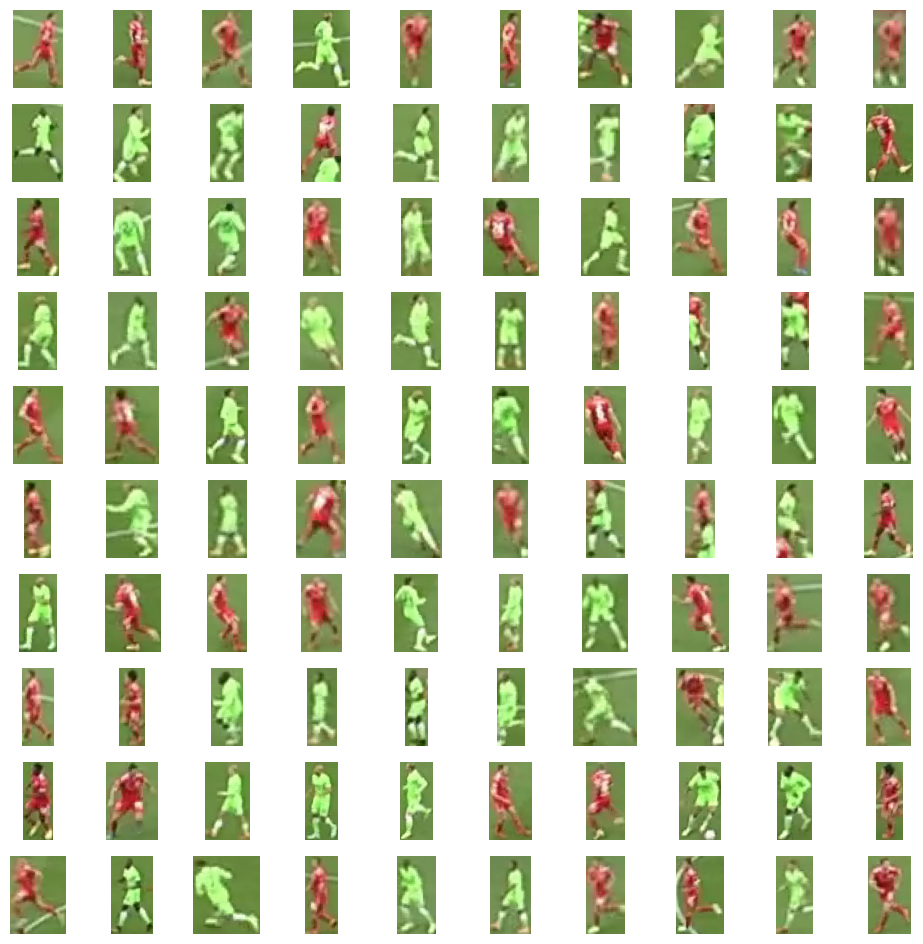

In [10]:
sv.plot_images_grid(crops[:100], grid_size=(10, 10))

In [11]:
import numpy as np
from more_itertools import chunked

BATCH_SIZE = 32

crops = [sv.cv2_to_pillow(crop) for crop in crops]
batches = chunked(crops, BATCH_SIZE)
data = []
with torch.no_grad():
    for batch in tqdm(batches, desc='embedding extraction'):
        inputs = EMBEDDINGS_PROCESSOR(images=batch, return_tensors="pt").to(DEVICE)
        outputs = EMBEDDINGS_MODEL(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
        data.append(embeddings)

data = np.concatenate(data)

embedding extraction: 11it [00:02,  5.13it/s]

embedding extraction: 16it [00:03,  5.21it/s]


In [12]:
import umap
from sklearn.cluster import KMeans

REDUCER = umap.UMAP(n_components=3)
CLUSTERING_MODEL = KMeans(n_clusters=2)

In [13]:
projections = REDUCER.fit_transform(data)
clusters = CLUSTERING_MODEL.fit_predict(projections)

In [14]:
import supervision as sv
from tqdm import tqdm
from sports.common.team import TeamClassifier

PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    # result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3)[0]
    # detections = sv.Detections.from_inference(result)
    detections = sv.Detections.from_ultralytics(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier(device="cuda")
team_classifier.fit(crops)

collecting crops: 0it [00:00, ?it/s]


0: 1280x1280 1 ball, 2 goalkeepers, 20 players, 2 referees, 65.8ms
Speed: 6.5ms preprocess, 65.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 1it [00:00,  8.97it/s]


0: 1280x1280 1 goalkeeper, 20 players, 2 referees, 66.3ms
Speed: 9.7ms preprocess, 66.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 2it [00:00,  6.99it/s]


0: 1280x1280 1 goalkeeper, 21 players, 2 referees, 65.8ms
Speed: 6.5ms preprocess, 65.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 3it [00:00,  6.51it/s]


0: 1280x1280 20 players, 2 referees, 66.3ms
Speed: 11.1ms preprocess, 66.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 4it [00:00,  6.43it/s]


0: 1280x1280 1 ball, 20 players, 2 referees, 66.0ms
Speed: 11.1ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 5it [00:00,  6.18it/s]


0: 1280x1280 1 ball, 20 players, 2 referees, 65.8ms
Speed: 10.9ms preprocess, 65.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 6it [00:00,  6.20it/s]


0: 1280x1280 20 players, 2 referees, 66.2ms
Speed: 7.9ms preprocess, 66.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 7it [00:01,  6.13it/s]


0: 1280x1280 1 ball, 19 players, 2 referees, 66.2ms
Speed: 10.0ms preprocess, 66.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 8it [00:01,  6.17it/s]


0: 1280x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 66.0ms
Speed: 8.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 9it [00:01,  6.14it/s]


0: 1280x1280 1 ball, 21 players, 2 referees, 66.3ms
Speed: 8.1ms preprocess, 66.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 10it [00:01,  6.01it/s]


0: 1280x1280 1 ball, 22 players, 2 referees, 66.3ms
Speed: 10.8ms preprocess, 66.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 11it [00:01,  5.99it/s]


0: 1280x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 66.4ms
Speed: 8.0ms preprocess, 66.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 12it [00:01,  5.95it/s]


0: 1280x1280 1 goalkeeper, 21 players, 2 referees, 66.1ms
Speed: 13.5ms preprocess, 66.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 13it [00:02,  5.94it/s]


0: 1280x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 66.2ms
Speed: 7.8ms preprocess, 66.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 14it [00:02,  5.91it/s]


0: 1280x1280 1 goalkeeper, 21 players, 2 referees, 65.8ms
Speed: 12.0ms preprocess, 65.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 15it [00:02,  5.97it/s]


0: 1280x1280 21 players, 2 referees, 66.0ms
Speed: 8.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 16it [00:02,  5.93it/s]


0: 1280x1280 20 players, 3 referees, 66.4ms
Speed: 12.1ms preprocess, 66.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 17it [00:02,  5.95it/s]


0: 1280x1280 22 players, 1 referee, 65.7ms
Speed: 11.6ms preprocess, 65.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 18it [00:02,  5.93it/s]


0: 1280x1280 22 players, 2 referees, 66.1ms
Speed: 13.2ms preprocess, 66.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 19it [00:03,  5.85it/s]


0: 1280x1280 23 players, 2 referees, 66.2ms
Speed: 12.2ms preprocess, 66.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 20it [00:03,  5.93it/s]


0: 1280x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 66.2ms
Speed: 7.8ms preprocess, 66.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 21it [00:03,  5.92it/s]


0: 1280x1280 1 goalkeeper, 21 players, 2 referees, 66.7ms
Speed: 8.6ms preprocess, 66.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 22it [00:03,  6.03it/s]


0: 1280x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 66.2ms
Speed: 8.4ms preprocess, 66.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 23it [00:03,  5.97it/s]


0: 1280x1280 1 goalkeeper, 22 players, 1 referee, 65.7ms
Speed: 11.7ms preprocess, 65.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 24it [00:03,  6.04it/s]


0: 1280x1280 1 goalkeeper, 22 players, 2 referees, 66.0ms
Speed: 8.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


collecting crops: 25it [00:04,  5.97it/s]
Embedding extraction: 19it [00:03,  4.97it/s]


In [ ]:
import joblib

MODEL_SAVE_DIR = "app/models/team_classifiers"  # Change this to your desired directory
import os
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# 1. Save SigLIP model and processor
EMBEDDINGS_MODEL.save_pretrained(f"{MODEL_SAVE_DIR}/siglip_model")
EMBEDDINGS_PROCESSOR.save_pretrained(f"{MODEL_SAVE_DIR}/siglip_model")

# 2. Save UMAP reducer
joblib.dump(REDUCER, f"{MODEL_SAVE_DIR}/umap_reducer.joblib")

# 3. Save KMeans model
joblib.dump(CLUSTERING_MODEL, f"{MODEL_SAVE_DIR}/kmeans_model.joblib")

# 4. Save TeamClassifier
# If it has a save method:
# team_classifier.save(f"{MODEL_SAVE_DIR}/team_classifier")
joblib.dump(team_classifier, f"{MODEL_SAVE_DIR}/team_classifier.joblib")

# Otherwise:
# np.save(f"{MODEL_SAVE_DIR}/team_classifier_embeddings.npy", team_classifier.embeddings_)
# np.save(f"{MODEL_SAVE_DIR}/team_classifier_labels.npy", team_classifier.labels_)

print("All models saved successfully!")

In [15]:
import numpy as np
import supervision as sv

def resolve_goalkeepers_team_id(
    players: sv.Detections,
    goalkeepers: sv.Detections
) -> np.ndarray:
    goalkeepers_xy = goalkeepers.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    team_0_centroid = players_xy[players.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[players.class_id == 1].mean(axis=0)
    goalkeepers_team_id = []
    for goalkeeper_xy in goalkeepers_xy:
        dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
        dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
        goalkeepers_team_id.append(0 if dist_0 < dist_1 else 1)

    return np.array(goalkeepers_team_id)


0: 1280x1280 1 ball, 2 goalkeepers, 20 players, 2 referees, 66.2ms
Speed: 11.0ms preprocess, 66.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 0it [00:00, ?it/s]

Embedding extraction: 1it [00:00,  8.70it/s]


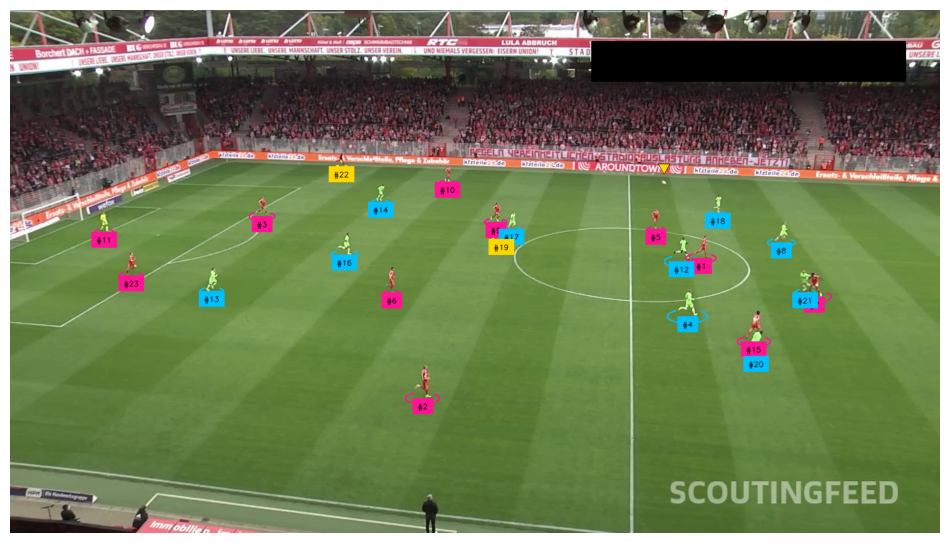

In [16]:
import supervision as sv

BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

# result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3)[0]
# detections = sv.Detections.from_inference(result)
detections = sv.Detections.from_ultralytics(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(detections=all_detections)

goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
players_detections = all_detections[all_detections.class_id == PLAYER_ID]
referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
    players_detections, goalkeepers_detections)

referees_detections.class_id -= 1

all_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections, referees_detections])

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

all_detections.class_id = all_detections.class_id.astype(int)

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

In [18]:
import supervision as sv
from tqdm import tqdm
import numpy as np
import cv2

# ----- Configuration and Annotators -----
SOURCE_VIDEO_PATH = "app/test_data/raw/sr2.mp4"
OUTPUT_VIDEO_PATH = "capitano_masr.mp4"

# Class IDs (as used in your training)
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)
# (Assuming that sv.StrongSORT is available and provides an update(frame) method.)
tracker = sv.ByteTrack()
tracker.reset()

# ----- INITIAL DETECTION AND CLASS ASSIGNMENT ON FIRST FRAME -----
# Create a generator for frames (stride=1 for the first frame)
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH, stride=1)
first_frame = next(frame_generator)
height, width = first_frame.shape[:2]
fps = 30  # Set this to the desired frames per second


# Initialize the OpenCV video writer for saving the annotated video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(OUTPUT_VIDEO_PATH, fourcc, fps, (width, height))

def process_frame(frame):
    # Run the detection model on the first frame using your local pretrained weights.
    result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3)[0]
    detections = sv.Detections.from_ultralytics(result)

    # Separate ball detections and pad their boxes.
    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

    # For all other detections, apply non-maximum suppression.
    all_detections = detections[detections.class_id != BALL_ID]
    all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)

    # Process player detections with your team classifier.
    players_detections = all_detections[all_detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
    players_detections.class_id = team_classifier.predict(players_crops)

    # Process goalkeeper detections using the helper function.
    goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
    if len(goalkeepers_detections) > 0:
        goalkeepers_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)

    # Adjust referee detections.
    referees_detections = all_detections[all_detections.class_id == REFEREE_ID]
    referees_detections.class_id -= 1

    # Merge the detections (players, goalkeepers, referees) for tracker initialization.
    initial_detections = sv.Detections.merge([
        players_detections, goalkeepers_detections, referees_detections
    ])

    # ----- INITIALIZE THE STRONGSORT TRACKER -----
    initial_detections = tracker.update_with_detections(detections=initial_detections)

    # Annotate the first frame.
    labels = [f"#{tid}" for tid in initial_detections.tracker_id]

    annotated_frame = frame.copy()
    annotated_frame = ellipse_annotator.annotate(scene=annotated_frame, detections=initial_detections)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=initial_detections, labels=labels)
    annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=ball_detections)
    return annotated_frame

# Process the first frame and write it to the video file
total_frames = fps * 20  # Process 10 seconds of video
annotated_first_frame = process_frame(first_frame)
video_writer.write(annotated_first_frame)

# Using tqdm to show progress for the remaining frames
with tqdm(total=total_frames - 1, desc="Processing frames") as pbar:
    for _ in range(total_frames - 1):
        try:
            frame = next(frame_generator)
        except StopIteration:
            break  # video ended before 10 seconds
        annotated_frame = process_frame(frame)
        video_writer.write(annotated_frame)
        pbar.update(1)

# Finalize the video file
video_writer.release()


0: 1280x1280 16 players, 66.2ms
Speed: 6.7ms preprocess, 66.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 0it [00:00, ?it/s]

Embedding extraction: 1it [00:00, 10.81it/s]
Processing frames:   0%|          | 0/599 [00:00<?, ?it/s]


0: 1280x1280 16 players, 67.2ms
Speed: 5.9ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.77it/s]
Processing frames:   0%|          | 1/599 [00:00<02:03,  4.84it/s]


0: 1280x1280 16 players, 66.6ms
Speed: 5.8ms preprocess, 66.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.86it/s]
Processing frames:   0%|          | 2/599 [00:00<02:02,  4.87it/s]


0: 1280x1280 16 players, 66.7ms
Speed: 5.9ms preprocess, 66.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.74it/s]
Processing frames:   1%|          | 3/599 [00:00<02:01,  4.89it/s]


0: 1280x1280 16 players, 66.7ms
Speed: 5.8ms preprocess, 66.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.74it/s]
Processing frames:   1%|          | 4/599 [00:00<02:01,  4.92it/s]


0: 1280x1280 16 players, 67.2ms
Speed: 6.9ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.80it/s]
Processing frames:   1%|          | 5/599 [00:01<02:01,  4.90it/s]


0: 1280x1280 16 players, 66.9ms
Speed: 5.9ms preprocess, 66.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.78it/s]
Processing frames:   1%|          | 6/599 [00:01<02:01,  4.89it/s]


0: 1280x1280 16 players, 67.3ms
Speed: 5.8ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.76it/s]
Processing frames:   1%|          | 7/599 [00:01<02:00,  4.91it/s]


0: 1280x1280 16 players, 67.0ms
Speed: 5.8ms preprocess, 67.0ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.76it/s]
Processing frames:   1%|▏         | 8/599 [00:01<02:00,  4.91it/s]


0: 1280x1280 16 players, 66.5ms
Speed: 5.7ms preprocess, 66.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.79it/s]
Processing frames:   2%|▏         | 9/599 [00:01<01:59,  4.93it/s]


0: 1280x1280 16 players, 66.9ms
Speed: 6.7ms preprocess, 66.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.80it/s]
Processing frames:   2%|▏         | 10/599 [00:02<01:59,  4.93it/s]


0: 1280x1280 16 players, 67.2ms
Speed: 6.8ms preprocess, 67.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.75it/s]
Processing frames:   2%|▏         | 11/599 [00:02<01:59,  4.91it/s]


0: 1280x1280 16 players, 67.2ms
Speed: 5.8ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.81it/s]
Processing frames:   2%|▏         | 12/599 [00:02<01:59,  4.91it/s]


0: 1280x1280 16 players, 67.0ms
Speed: 7.9ms preprocess, 67.0ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.84it/s]
Processing frames:   2%|▏         | 13/599 [00:02<01:59,  4.90it/s]


0: 1280x1280 16 players, 66.4ms
Speed: 7.2ms preprocess, 66.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.74it/s]
Processing frames:   2%|▏         | 14/599 [00:02<01:59,  4.90it/s]


0: 1280x1280 16 players, 67.0ms
Speed: 7.5ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.76it/s]
Processing frames:   3%|▎         | 15/599 [00:03<01:58,  4.91it/s]


0: 1280x1280 16 players, 67.5ms
Speed: 6.0ms preprocess, 67.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.76it/s]
Processing frames:   3%|▎         | 16/599 [00:03<01:58,  4.92it/s]


0: 1280x1280 16 players, 67.2ms
Speed: 5.8ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.74it/s]
Processing frames:   3%|▎         | 17/599 [00:03<01:58,  4.92it/s]


0: 1280x1280 16 players, 66.9ms
Speed: 7.4ms preprocess, 66.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.83it/s]
Processing frames:   3%|▎         | 18/599 [00:03<01:57,  4.93it/s]


0: 1280x1280 16 players, 67.2ms
Speed: 5.7ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.78it/s]
Processing frames:   3%|▎         | 19/599 [00:03<01:57,  4.94it/s]


0: 1280x1280 16 players, 67.4ms
Speed: 5.8ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.77it/s]
Processing frames:   3%|▎         | 20/599 [00:04<01:57,  4.94it/s]


0: 1280x1280 16 players, 66.4ms
Speed: 7.9ms preprocess, 66.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.73it/s]
Processing frames:   4%|▎         | 21/599 [00:04<01:57,  4.93it/s]


0: 1280x1280 16 players, 66.5ms
Speed: 5.8ms preprocess, 66.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.74it/s]
Processing frames:   4%|▎         | 22/599 [00:04<01:57,  4.93it/s]


0: 1280x1280 16 players, 67.0ms
Speed: 5.7ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.81it/s]
Processing frames:   4%|▍         | 23/599 [00:04<01:56,  4.93it/s]


0: 1280x1280 16 players, 67.5ms
Speed: 5.8ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.77it/s]
Processing frames:   4%|▍         | 24/599 [00:04<01:56,  4.92it/s]


0: 1280x1280 16 players, 66.7ms
Speed: 5.9ms preprocess, 66.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.80it/s]
Processing frames:   4%|▍         | 25/599 [00:05<01:56,  4.94it/s]


0: 1280x1280 16 players, 67.0ms
Speed: 5.8ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.68it/s]
Processing frames:   4%|▍         | 26/599 [00:05<01:56,  4.90it/s]


0: 1280x1280 16 players, 66.5ms
Speed: 5.9ms preprocess, 66.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.14it/s]
Processing frames:   5%|▍         | 27/599 [00:05<01:57,  4.89it/s]


0: 1280x1280 16 players, 67.4ms
Speed: 7.3ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.75it/s]
Processing frames:   5%|▍         | 28/599 [00:05<01:56,  4.88it/s]


0: 1280x1280 16 players, 66.9ms
Speed: 5.8ms preprocess, 66.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.84it/s]
Processing frames:   5%|▍         | 29/599 [00:05<01:56,  4.89it/s]


0: 1280x1280 16 players, 66.8ms
Speed: 6.8ms preprocess, 66.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.67it/s]
Processing frames:   5%|▌         | 30/599 [00:06<01:56,  4.87it/s]


0: 1280x1280 16 players, 67.2ms
Speed: 6.1ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.75it/s]
Processing frames:   5%|▌         | 31/599 [00:06<01:56,  4.89it/s]


0: 1280x1280 16 players, 67.4ms
Speed: 5.8ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.77it/s]
Processing frames:   5%|▌         | 32/599 [00:06<01:55,  4.89it/s]


0: 1280x1280 16 players, 66.9ms
Speed: 5.8ms preprocess, 66.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.67it/s]
Processing frames:   6%|▌         | 33/599 [00:06<01:55,  4.91it/s]


0: 1280x1280 1 ball, 16 players, 67.1ms
Speed: 5.8ms preprocess, 67.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.84it/s]
Processing frames:   6%|▌         | 34/599 [00:06<01:54,  4.91it/s]


0: 1280x1280 1 ball, 16 players, 67.2ms
Speed: 5.9ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.75it/s]
Processing frames:   6%|▌         | 35/599 [00:07<01:54,  4.91it/s]


0: 1280x1280 1 ball, 16 players, 66.9ms
Speed: 5.8ms preprocess, 66.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.70it/s]
Processing frames:   6%|▌         | 36/599 [00:07<01:55,  4.89it/s]


0: 1280x1280 17 players, 67.0ms
Speed: 7.5ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.10it/s]
Processing frames:   6%|▌         | 37/599 [00:07<01:56,  4.83it/s]


0: 1280x1280 19 players, 1 referee, 66.9ms
Speed: 6.3ms preprocess, 66.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.34it/s]
Processing frames:   6%|▋         | 38/599 [00:07<01:58,  4.72it/s]


0: 1280x1280 17 players, 1 referee, 66.2ms
Speed: 5.9ms preprocess, 66.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.11it/s]
Processing frames:   7%|▋         | 39/599 [00:07<01:58,  4.72it/s]


0: 1280x1280 17 players, 1 referee, 67.1ms
Speed: 6.0ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.95it/s]
Processing frames:   7%|▋         | 40/599 [00:08<01:56,  4.79it/s]


0: 1280x1280 1 ball, 19 players, 3 referees, 67.1ms
Speed: 6.0ms preprocess, 67.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.47it/s]
Processing frames:   7%|▋         | 41/599 [00:08<01:58,  4.69it/s]


0: 1280x1280 19 players, 3 referees, 66.6ms
Speed: 5.9ms preprocess, 66.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.38it/s]
Processing frames:   7%|▋         | 42/599 [00:08<01:59,  4.65it/s]


0: 1280x1280 15 players, 2 referees, 66.7ms
Speed: 6.0ms preprocess, 66.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 11.02it/s]
Processing frames:   7%|▋         | 43/599 [00:08<01:57,  4.74it/s]


0: 1280x1280 19 players, 2 referees, 66.8ms
Speed: 5.9ms preprocess, 66.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.03it/s]
Processing frames:   7%|▋         | 44/599 [00:09<01:57,  4.73it/s]


0: 1280x1280 18 players, 2 referees, 67.0ms
Speed: 8.8ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.79it/s]
Processing frames:   8%|▊         | 45/599 [00:09<01:56,  4.75it/s]


0: 1280x1280 18 players, 2 referees, 66.6ms
Speed: 5.8ms preprocess, 66.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.14it/s]
Processing frames:   8%|▊         | 46/599 [00:09<01:56,  4.76it/s]


0: 1280x1280 18 players, 2 referees, 66.8ms
Speed: 6.2ms preprocess, 66.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.73it/s]
Processing frames:   8%|▊         | 47/599 [00:09<01:55,  4.77it/s]


0: 1280x1280 16 players, 66.3ms
Speed: 8.4ms preprocess, 66.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 11.62it/s]
Processing frames:   8%|▊         | 48/599 [00:09<01:53,  4.85it/s]


0: 1280x1280 16 players, 2 referees, 67.1ms
Speed: 5.9ms preprocess, 67.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 11.60it/s]
Processing frames:   8%|▊         | 49/599 [00:10<01:52,  4.90it/s]


0: 1280x1280 17 players, 2 referees, 67.2ms
Speed: 5.8ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.09it/s]
Processing frames:   8%|▊         | 50/599 [00:10<01:53,  4.83it/s]


0: 1280x1280 16 players, 1 referee, 66.8ms
Speed: 5.8ms preprocess, 66.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 11.61it/s]
Processing frames:   9%|▊         | 51/599 [00:10<01:51,  4.90it/s]


0: 1280x1280 16 players, 1 referee, 67.4ms
Speed: 5.7ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 11.63it/s]
Processing frames:   9%|▊         | 52/599 [00:10<01:50,  4.95it/s]


0: 1280x1280 1 ball, 16 players, 67.0ms
Speed: 5.8ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.74it/s]
Processing frames:   9%|▉         | 53/599 [00:10<01:51,  4.92it/s]


0: 1280x1280 16 players, 66.5ms
Speed: 5.9ms preprocess, 66.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.74it/s]
Processing frames:   9%|▉         | 54/599 [00:11<01:51,  4.91it/s]


0: 1280x1280 1 ball, 16 players, 66.9ms
Speed: 6.0ms preprocess, 66.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 11.65it/s]
Processing frames:   9%|▉         | 55/599 [00:11<01:50,  4.94it/s]


0: 1280x1280 1 ball, 18 players, 67.1ms
Speed: 5.9ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.72it/s]
Processing frames:   9%|▉         | 56/599 [00:11<01:51,  4.89it/s]


0: 1280x1280 18 players, 1 referee, 66.6ms
Speed: 9.1ms preprocess, 66.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.78it/s]
Processing frames:  10%|▉         | 57/599 [00:11<01:51,  4.86it/s]


0: 1280x1280 17 players, 1 referee, 66.9ms
Speed: 8.2ms preprocess, 66.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.06it/s]
Processing frames:  10%|▉         | 58/599 [00:11<01:52,  4.81it/s]


0: 1280x1280 15 players, 67.3ms
Speed: 6.5ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.55it/s]
Processing frames:  10%|▉         | 59/599 [00:12<01:50,  4.89it/s]


0: 1280x1280 15 players, 2 referees, 66.5ms
Speed: 5.8ms preprocess, 66.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 11.52it/s]
Processing frames:  10%|█         | 60/599 [00:12<01:49,  4.94it/s]


0: 1280x1280 14 players, 3 referees, 66.6ms
Speed: 5.7ms preprocess, 66.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.56it/s]
Processing frames:  10%|█         | 61/599 [00:12<01:47,  5.03it/s]


0: 1280x1280 14 players, 66.9ms
Speed: 5.9ms preprocess, 66.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.60it/s]
Processing frames:  10%|█         | 62/599 [00:12<01:45,  5.07it/s]


0: 1280x1280 15 players, 2 referees, 66.9ms
Speed: 5.8ms preprocess, 66.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.43it/s]
Processing frames:  11%|█         | 63/599 [00:12<01:44,  5.11it/s]


0: 1280x1280 14 players, 2 referees, 67.0ms
Speed: 7.5ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.33it/s]
Processing frames:  11%|█         | 64/599 [00:13<01:43,  5.18it/s]


0: 1280x1280 16 players, 2 referees, 66.9ms
Speed: 5.9ms preprocess, 66.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.76it/s]
Processing frames:  11%|█         | 65/599 [00:13<01:45,  5.07it/s]


0: 1280x1280 17 players, 2 referees, 66.8ms
Speed: 5.9ms preprocess, 66.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.71it/s]
Processing frames:  11%|█         | 66/599 [00:13<01:46,  5.01it/s]


0: 1280x1280 17 players, 2 referees, 67.0ms
Speed: 5.8ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.71it/s]
Processing frames:  11%|█         | 67/599 [00:13<01:46,  4.98it/s]


0: 1280x1280 16 players, 66.6ms
Speed: 5.9ms preprocess, 66.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 11.62it/s]
Processing frames:  11%|█▏        | 68/599 [00:13<01:46,  5.00it/s]


0: 1280x1280 15 players, 2 referees, 66.5ms
Speed: 8.3ms preprocess, 66.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 11.58it/s]
Processing frames:  12%|█▏        | 69/599 [00:14<01:46,  4.99it/s]


0: 1280x1280 15 players, 66.7ms
Speed: 5.8ms preprocess, 66.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.60it/s]
Processing frames:  12%|█▏        | 70/599 [00:14<01:44,  5.06it/s]


0: 1280x1280 14 players, 1 referee, 66.8ms
Speed: 5.8ms preprocess, 66.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.57it/s]
Processing frames:  12%|█▏        | 71/599 [00:14<01:43,  5.09it/s]


0: 1280x1280 15 players, 67.1ms
Speed: 5.8ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 11.62it/s]
Processing frames:  12%|█▏        | 72/599 [00:14<01:43,  5.09it/s]


0: 1280x1280 15 players, 67.0ms
Speed: 8.1ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 11.59it/s]
Processing frames:  12%|█▏        | 73/599 [00:14<01:43,  5.06it/s]


0: 1280x1280 15 players, 1 referee, 66.4ms
Speed: 5.9ms preprocess, 66.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 11.49it/s]
Processing frames:  12%|█▏        | 74/599 [00:15<01:44,  5.04it/s]


0: 1280x1280 1 ball, 19 players, 66.4ms
Speed: 5.8ms preprocess, 66.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.37it/s]
Processing frames:  13%|█▎        | 75/599 [00:15<01:47,  4.87it/s]


0: 1280x1280 17 players, 1 referee, 67.2ms
Speed: 6.0ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.09it/s]
Processing frames:  13%|█▎        | 76/599 [00:15<01:48,  4.82it/s]


0: 1280x1280 1 ball, 17 players, 1 referee, 67.3ms
Speed: 6.0ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.72it/s]
Processing frames:  13%|█▎        | 77/599 [00:15<01:48,  4.81it/s]


0: 1280x1280 1 ball, 14 players, 67.0ms
Speed: 5.9ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.47it/s]
Processing frames:  13%|█▎        | 78/599 [00:15<01:45,  4.93it/s]


0: 1280x1280 1 ball, 14 players, 66.8ms
Speed: 8.0ms preprocess, 66.8ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.45it/s]
Processing frames:  13%|█▎        | 79/599 [00:16<01:44,  4.99it/s]


0: 1280x1280 19 players, 2 referees, 67.4ms
Speed: 5.9ms preprocess, 67.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.63it/s]
Processing frames:  13%|█▎        | 80/599 [00:16<01:45,  4.91it/s]


0: 1280x1280 18 players, 2 referees, 66.5ms
Speed: 5.9ms preprocess, 66.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.67it/s]
Processing frames:  14%|█▎        | 81/599 [00:16<01:45,  4.90it/s]


0: 1280x1280 16 players, 67.1ms
Speed: 5.7ms preprocess, 67.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 11.58it/s]
Processing frames:  14%|█▎        | 82/599 [00:16<01:44,  4.95it/s]


0: 1280x1280 17 players, 1 referee, 67.0ms
Speed: 5.8ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.74it/s]
Processing frames:  14%|█▍        | 83/599 [00:16<01:45,  4.91it/s]


0: 1280x1280 16 players, 1 referee, 67.0ms
Speed: 8.3ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 11.64it/s]
Processing frames:  14%|█▍        | 84/599 [00:17<01:44,  4.93it/s]


0: 1280x1280 15 players, 1 referee, 67.2ms
Speed: 7.9ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.55it/s]
Processing frames:  14%|█▍        | 85/599 [00:17<01:42,  5.00it/s]


0: 1280x1280 14 players, 1 referee, 67.1ms
Speed: 8.2ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.46it/s]
Processing frames:  14%|█▍        | 86/599 [00:17<01:42,  5.03it/s]


0: 1280x1280 16 players, 2 referees, 66.6ms
Speed: 5.9ms preprocess, 66.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.60it/s]
Processing frames:  15%|█▍        | 87/599 [00:17<01:43,  4.97it/s]


0: 1280x1280 15 players, 1 referee, 66.7ms
Speed: 8.0ms preprocess, 66.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 11.41it/s]
Processing frames:  15%|█▍        | 88/599 [00:17<01:42,  4.96it/s]


0: 1280x1280 16 players, 1 referee, 67.1ms
Speed: 5.7ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 11.57it/s]
Processing frames:  15%|█▍        | 89/599 [00:18<01:42,  4.97it/s]


0: 1280x1280 13 players, 67.1ms
Speed: 9.7ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.44it/s]
Processing frames:  15%|█▌        | 90/599 [00:18<01:40,  5.07it/s]


0: 1280x1280 1 ball, 13 players, 2 referees, 66.6ms
Speed: 5.8ms preprocess, 66.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.47it/s]
Processing frames:  15%|█▌        | 91/599 [00:18<01:38,  5.17it/s]


0: 1280x1280 1 ball, 14 players, 2 referees, 67.4ms
Speed: 6.0ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.52it/s]
Processing frames:  15%|█▌        | 92/599 [00:18<01:38,  5.16it/s]


0: 1280x1280 1 ball, 15 players, 1 referee, 66.7ms
Speed: 5.8ms preprocess, 66.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.61it/s]
Processing frames:  16%|█▌        | 93/599 [00:18<01:37,  5.18it/s]


0: 1280x1280 12 players, 1 referee, 66.9ms
Speed: 7.7ms preprocess, 66.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.65it/s]
Processing frames:  16%|█▌        | 94/599 [00:19<01:35,  5.29it/s]


0: 1280x1280 1 ball, 13 players, 67.1ms
Speed: 10.6ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.27it/s]
Processing frames:  16%|█▌        | 95/599 [00:19<01:35,  5.26it/s]


0: 1280x1280 1 ball, 11 players, 1 referee, 67.1ms
Speed: 5.9ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.75it/s]
Processing frames:  16%|█▌        | 96/599 [00:19<01:32,  5.42it/s]


0: 1280x1280 1 ball, 12 players, 1 referee, 67.3ms
Speed: 5.7ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.51it/s]
Processing frames:  16%|█▌        | 97/599 [00:19<01:30,  5.54it/s]


0: 1280x1280 1 ball, 14 players, 1 referee, 67.6ms
Speed: 6.9ms preprocess, 67.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.35it/s]
Processing frames:  16%|█▋        | 98/599 [00:19<01:31,  5.46it/s]


0: 1280x1280 12 players, 1 referee, 67.5ms
Speed: 5.8ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.60it/s]
Processing frames:  17%|█▋        | 99/599 [00:19<01:31,  5.49it/s]


0: 1280x1280 12 players, 1 referee, 67.4ms
Speed: 5.8ms preprocess, 67.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.71it/s]
Processing frames:  17%|█▋        | 100/599 [00:20<01:30,  5.53it/s]


0: 1280x1280 13 players, 1 referee, 67.4ms
Speed: 5.8ms preprocess, 67.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.57it/s]
Processing frames:  17%|█▋        | 101/599 [00:20<01:29,  5.54it/s]


0: 1280x1280 14 players, 1 referee, 67.3ms
Speed: 8.1ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.52it/s]
Processing frames:  17%|█▋        | 102/599 [00:20<01:31,  5.43it/s]


0: 1280x1280 14 players, 1 referee, 67.3ms
Speed: 5.8ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.48it/s]
Processing frames:  17%|█▋        | 103/599 [00:20<01:32,  5.37it/s]


0: 1280x1280 15 players, 1 referee, 67.2ms
Speed: 5.9ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.44it/s]
Processing frames:  17%|█▋        | 104/599 [00:20<01:33,  5.30it/s]


0: 1280x1280 14 players, 1 referee, 66.9ms
Speed: 8.7ms preprocess, 66.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.49it/s]
Processing frames:  18%|█▊        | 105/599 [00:21<01:34,  5.24it/s]


0: 1280x1280 13 players, 1 referee, 66.7ms
Speed: 9.1ms preprocess, 66.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.38it/s]
Processing frames:  18%|█▊        | 106/599 [00:21<01:33,  5.26it/s]


0: 1280x1280 14 players, 1 referee, 66.5ms
Speed: 9.5ms preprocess, 66.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.53it/s]
Processing frames:  18%|█▊        | 107/599 [00:21<01:34,  5.21it/s]


0: 1280x1280 15 players, 1 referee, 67.0ms
Speed: 5.9ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.57it/s]
Processing frames:  18%|█▊        | 108/599 [00:21<01:34,  5.21it/s]


0: 1280x1280 1 ball, 13 players, 1 referee, 67.2ms
Speed: 5.9ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.28it/s]
Processing frames:  18%|█▊        | 109/599 [00:21<01:33,  5.24it/s]


0: 1280x1280 13 players, 1 referee, 67.2ms
Speed: 7.8ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.31it/s]
Processing frames:  18%|█▊        | 110/599 [00:22<01:33,  5.22it/s]


0: 1280x1280 13 players, 1 referee, 67.1ms
Speed: 5.7ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.22it/s]
Processing frames:  19%|█▊        | 111/599 [00:22<01:32,  5.25it/s]


0: 1280x1280 12 players, 3 referees, 67.4ms
Speed: 7.0ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.57it/s]
Processing frames:  19%|█▊        | 112/599 [00:22<01:31,  5.34it/s]


0: 1280x1280 12 players, 2 referees, 66.9ms
Speed: 9.9ms preprocess, 66.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.49it/s]
Processing frames:  19%|█▉        | 113/599 [00:22<01:30,  5.36it/s]


0: 1280x1280 12 players, 2 referees, 66.8ms
Speed: 9.7ms preprocess, 66.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.72it/s]
Processing frames:  19%|█▉        | 114/599 [00:22<01:29,  5.40it/s]


0: 1280x1280 12 players, 2 referees, 66.9ms
Speed: 7.0ms preprocess, 66.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.58it/s]
Processing frames:  19%|█▉        | 115/599 [00:22<01:28,  5.47it/s]


0: 1280x1280 1 ball, 12 players, 66.6ms
Speed: 8.6ms preprocess, 66.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.78it/s]
Processing frames:  19%|█▉        | 116/599 [00:23<01:28,  5.47it/s]


0: 1280x1280 13 players, 1 referee, 66.6ms
Speed: 5.9ms preprocess, 66.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.66it/s]
Processing frames:  20%|█▉        | 117/599 [00:23<01:27,  5.53it/s]


0: 1280x1280 11 players, 66.9ms
Speed: 7.1ms preprocess, 66.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.72it/s]
Processing frames:  20%|█▉        | 118/599 [00:23<01:25,  5.60it/s]


0: 1280x1280 11 players, 1 referee, 67.5ms
Speed: 10.4ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.59it/s]
Processing frames:  20%|█▉        | 119/599 [00:23<01:25,  5.60it/s]


0: 1280x1280 12 players, 1 referee, 67.3ms
Speed: 10.2ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.65it/s]
Processing frames:  20%|██        | 120/599 [00:23<01:26,  5.56it/s]


0: 1280x1280 13 players, 1 referee, 67.0ms
Speed: 6.5ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.54it/s]
Processing frames:  20%|██        | 121/599 [00:24<01:25,  5.60it/s]


0: 1280x1280 1 ball, 12 players, 1 referee, 67.0ms
Speed: 8.6ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.54it/s]
Processing frames:  20%|██        | 122/599 [00:24<01:25,  5.56it/s]


0: 1280x1280 1 ball, 12 players, 2 referees, 67.3ms
Speed: 8.2ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.55it/s]
Processing frames:  21%|██        | 123/599 [00:24<01:25,  5.54it/s]


0: 1280x1280 1 ball, 12 players, 1 referee, 67.2ms
Speed: 5.8ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.58it/s]
Processing frames:  21%|██        | 124/599 [00:24<01:25,  5.57it/s]


0: 1280x1280 1 ball, 12 players, 1 referee, 67.2ms
Speed: 7.4ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.62it/s]
Processing frames:  21%|██        | 125/599 [00:24<01:25,  5.55it/s]


0: 1280x1280 1 ball, 12 players, 1 referee, 67.0ms
Speed: 5.8ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.56it/s]
Processing frames:  21%|██        | 126/599 [00:24<01:25,  5.56it/s]


0: 1280x1280 1 ball, 12 players, 1 referee, 67.2ms
Speed: 9.1ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.63it/s]
Processing frames:  21%|██        | 127/599 [00:25<01:24,  5.57it/s]


0: 1280x1280 1 ball, 12 players, 3 referees, 67.3ms
Speed: 9.1ms preprocess, 67.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.56it/s]
Processing frames:  21%|██▏       | 128/599 [00:25<01:25,  5.49it/s]


0: 1280x1280 1 ball, 12 players, 2 referees, 66.7ms
Speed: 5.8ms preprocess, 66.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.53it/s]
Processing frames:  22%|██▏       | 129/599 [00:25<01:25,  5.52it/s]


0: 1280x1280 1 ball, 12 players, 3 referees, 67.3ms
Speed: 5.8ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.58it/s]
Processing frames:  22%|██▏       | 130/599 [00:25<01:24,  5.55it/s]


0: 1280x1280 1 ball, 12 players, 2 referees, 67.5ms
Speed: 6.6ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.59it/s]
Processing frames:  22%|██▏       | 131/599 [00:25<01:24,  5.54it/s]


0: 1280x1280 2 balls, 16 players, 2 referees, 66.8ms
Speed: 8.1ms preprocess, 66.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 11.35it/s]
Processing frames:  22%|██▏       | 132/599 [00:26<01:27,  5.36it/s]


0: 1280x1280 2 balls, 16 players, 2 referees, 66.6ms
Speed: 8.1ms preprocess, 66.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 11.41it/s]
Processing frames:  22%|██▏       | 133/599 [00:26<01:28,  5.25it/s]


0: 1280x1280 1 ball, 15 players, 2 referees, 67.4ms
Speed: 5.8ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.47it/s]
Processing frames:  22%|██▏       | 134/599 [00:26<01:29,  5.17it/s]


0: 1280x1280 1 ball, 14 players, 2 referees, 67.1ms
Speed: 5.8ms preprocess, 67.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.49it/s]
Processing frames:  23%|██▎       | 135/599 [00:26<01:29,  5.18it/s]


0: 1280x1280 1 ball, 14 players, 3 referees, 67.3ms
Speed: 5.8ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.53it/s]
Processing frames:  23%|██▎       | 136/599 [00:26<01:29,  5.19it/s]


0: 1280x1280 1 ball, 14 players, 3 referees, 67.3ms
Speed: 7.6ms preprocess, 67.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.26it/s]
Processing frames:  23%|██▎       | 137/599 [00:27<01:28,  5.20it/s]


0: 1280x1280 1 ball, 13 players, 3 referees, 67.1ms
Speed: 5.7ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.70it/s]
Processing frames:  23%|██▎       | 138/599 [00:27<01:27,  5.28it/s]


0: 1280x1280 1 ball, 13 players, 3 referees, 67.1ms
Speed: 5.9ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.29it/s]
Processing frames:  23%|██▎       | 139/599 [00:27<01:26,  5.32it/s]


0: 1280x1280 1 ball, 14 players, 3 referees, 66.8ms
Speed: 7.8ms preprocess, 66.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.33it/s]
Processing frames:  23%|██▎       | 140/599 [00:27<01:27,  5.24it/s]


0: 1280x1280 16 players, 3 referees, 66.9ms
Speed: 5.8ms preprocess, 66.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.56it/s]
Processing frames:  24%|██▎       | 141/599 [00:27<01:27,  5.22it/s]


0: 1280x1280 1 ball, 15 players, 4 referees, 67.2ms
Speed: 5.9ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.35it/s]
Processing frames:  24%|██▎       | 142/599 [00:27<01:27,  5.21it/s]


0: 1280x1280 14 players, 4 referees, 67.2ms
Speed: 6.3ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.45it/s]
Processing frames:  24%|██▍       | 143/599 [00:28<01:28,  5.18it/s]


0: 1280x1280 16 players, 3 referees, 67.5ms
Speed: 9.1ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.42it/s]
Processing frames:  24%|██▍       | 144/599 [00:28<01:28,  5.15it/s]


0: 1280x1280 16 players, 3 referees, 67.2ms
Speed: 5.8ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.44it/s]
Processing frames:  24%|██▍       | 145/599 [00:28<01:27,  5.18it/s]


0: 1280x1280 18 players, 3 referees, 67.4ms
Speed: 5.8ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.61it/s]
Processing frames:  24%|██▍       | 146/599 [00:28<01:29,  5.03it/s]


0: 1280x1280 1 ball, 14 players, 3 referees, 66.6ms
Speed: 8.1ms preprocess, 66.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.42it/s]
Processing frames:  25%|██▍       | 147/599 [00:28<01:28,  5.12it/s]


0: 1280x1280 1 ball, 17 players, 1 referee, 67.6ms
Speed: 6.7ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 11.57it/s]
Processing frames:  25%|██▍       | 148/599 [00:29<01:28,  5.09it/s]


0: 1280x1280 1 ball, 14 players, 2 referees, 67.4ms
Speed: 5.9ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.38it/s]
Processing frames:  25%|██▍       | 149/599 [00:29<01:28,  5.10it/s]


0: 1280x1280 14 players, 2 referees, 66.7ms
Speed: 5.9ms preprocess, 66.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.48it/s]
Processing frames:  25%|██▌       | 150/599 [00:29<01:27,  5.14it/s]


0: 1280x1280 14 players, 2 referees, 67.0ms
Speed: 9.0ms preprocess, 67.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.51it/s]
Processing frames:  25%|██▌       | 151/599 [00:29<01:26,  5.15it/s]


0: 1280x1280 16 players, 2 referees, 67.2ms
Speed: 8.7ms preprocess, 67.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 11.55it/s]
Processing frames:  25%|██▌       | 152/599 [00:29<01:27,  5.08it/s]


0: 1280x1280 15 players, 1 referee, 67.1ms
Speed: 5.9ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.42it/s]
Processing frames:  26%|██▌       | 153/599 [00:30<01:27,  5.12it/s]


0: 1280x1280 17 players, 2 referees, 66.5ms
Speed: 6.0ms preprocess, 66.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.69it/s]
Processing frames:  26%|██▌       | 154/599 [00:30<01:28,  5.03it/s]


0: 1280x1280 15 players, 1 referee, 67.4ms
Speed: 5.9ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.44it/s]
Processing frames:  26%|██▌       | 155/599 [00:30<01:27,  5.06it/s]


0: 1280x1280 13 players, 2 referees, 66.9ms
Speed: 6.1ms preprocess, 66.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.50it/s]
Processing frames:  26%|██▌       | 156/599 [00:30<01:24,  5.22it/s]


0: 1280x1280 13 players, 2 referees, 67.2ms
Speed: 8.2ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.61it/s]
Processing frames:  26%|██▌       | 157/599 [00:30<01:23,  5.33it/s]


0: 1280x1280 15 players, 2 referees, 67.0ms
Speed: 9.7ms preprocess, 67.0ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 11.39it/s]
Processing frames:  26%|██▋       | 158/599 [00:31<01:25,  5.16it/s]


0: 1280x1280 14 players, 2 referees, 67.3ms
Speed: 5.8ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.18it/s]
Processing frames:  27%|██▋       | 159/599 [00:31<01:24,  5.20it/s]


0: 1280x1280 12 players, 1 referee, 67.2ms
Speed: 6.3ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.56it/s]
Processing frames:  27%|██▋       | 160/599 [00:31<01:22,  5.32it/s]


0: 1280x1280 12 players, 1 referee, 67.8ms
Speed: 5.9ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.51it/s]
Processing frames:  27%|██▋       | 161/599 [00:31<01:20,  5.42it/s]


0: 1280x1280 1 ball, 11 players, 1 referee, 67.2ms
Speed: 9.1ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.73it/s]
Processing frames:  27%|██▋       | 162/599 [00:31<01:19,  5.51it/s]


0: 1280x1280 1 ball, 12 players, 1 referee, 67.4ms
Speed: 8.8ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.54it/s]
Processing frames:  27%|██▋       | 163/599 [00:31<01:18,  5.53it/s]


0: 1280x1280 10 players, 1 referee, 67.3ms
Speed: 6.3ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.56it/s]
Processing frames:  27%|██▋       | 164/599 [00:32<01:16,  5.66it/s]


0: 1280x1280 10 players, 1 referee, 67.4ms
Speed: 8.1ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.36it/s]
Processing frames:  28%|██▊       | 165/599 [00:32<01:15,  5.72it/s]


0: 1280x1280 12 players, 1 referee, 67.6ms
Speed: 8.7ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.61it/s]
Processing frames:  28%|██▊       | 166/599 [00:32<01:15,  5.71it/s]


0: 1280x1280 11 players, 2 referees, 67.2ms
Speed: 5.9ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.52it/s]
Processing frames:  28%|██▊       | 167/599 [00:32<01:14,  5.80it/s]


0: 1280x1280 12 players, 3 referees, 67.4ms
Speed: 8.6ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.41it/s]
Processing frames:  28%|██▊       | 168/599 [00:32<01:14,  5.76it/s]


0: 1280x1280 12 players, 3 referees, 66.8ms
Speed: 6.5ms preprocess, 66.8ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.63it/s]
Processing frames:  28%|██▊       | 169/599 [00:33<01:14,  5.79it/s]


0: 1280x1280 12 players, 2 referees, 67.5ms
Speed: 9.3ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.44it/s]
Processing frames:  28%|██▊       | 170/599 [00:33<01:14,  5.73it/s]


0: 1280x1280 11 players, 1 referee, 67.4ms
Speed: 8.3ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.31it/s]
Processing frames:  29%|██▊       | 171/599 [00:33<01:12,  5.87it/s]


0: 1280x1280 9 players, 1 referee, 67.2ms
Speed: 7.1ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 21.76it/s]
Processing frames:  29%|██▊       | 172/599 [00:33<01:10,  6.07it/s]


0: 1280x1280 10 players, 2 referees, 67.8ms
Speed: 5.9ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.60it/s]
Processing frames:  29%|██▉       | 173/599 [00:33<01:10,  6.05it/s]


0: 1280x1280 9 players, 1 referee, 67.3ms
Speed: 5.9ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.78it/s]
Processing frames:  29%|██▉       | 174/599 [00:33<01:09,  6.15it/s]


0: 1280x1280 9 players, 1 referee, 67.8ms
Speed: 5.7ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 22.08it/s]
Processing frames:  29%|██▉       | 175/599 [00:33<01:07,  6.31it/s]


0: 1280x1280 1 ball, 11 players, 1 referee, 67.7ms
Speed: 5.9ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.52it/s]
Processing frames:  29%|██▉       | 176/599 [00:34<01:08,  6.20it/s]


0: 1280x1280 1 ball, 12 players, 1 referee, 66.9ms
Speed: 5.8ms preprocess, 66.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.80it/s]
Processing frames:  30%|██▉       | 177/599 [00:34<01:08,  6.19it/s]


0: 1280x1280 10 players, 1 referee, 67.8ms
Speed: 5.9ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 18.02it/s]
Processing frames:  30%|██▉       | 178/599 [00:34<01:08,  6.18it/s]


0: 1280x1280 1 ball, 10 players, 1 referee, 66.9ms
Speed: 6.0ms preprocess, 66.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.63it/s]
Processing frames:  30%|██▉       | 179/599 [00:34<01:08,  6.13it/s]


0: 1280x1280 12 players, 1 referee, 67.6ms
Speed: 5.9ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.57it/s]
Processing frames:  30%|███       | 180/599 [00:34<01:10,  5.97it/s]


0: 1280x1280 12 players, 1 referee, 67.2ms
Speed: 5.8ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.45it/s]
Processing frames:  30%|███       | 181/599 [00:34<01:11,  5.87it/s]


0: 1280x1280 12 players, 1 referee, 67.8ms
Speed: 5.9ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.52it/s]
Processing frames:  30%|███       | 182/599 [00:35<01:12,  5.76it/s]


0: 1280x1280 11 players, 1 referee, 67.0ms
Speed: 8.6ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.34it/s]
Processing frames:  31%|███       | 183/599 [00:35<01:12,  5.74it/s]


0: 1280x1280 1 ball, 13 players, 1 referee, 68.1ms
Speed: 5.9ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.54it/s]
Processing frames:  31%|███       | 184/599 [00:35<01:12,  5.75it/s]


0: 1280x1280 16 players, 2 referees, 67.1ms
Speed: 10.1ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.09it/s]
Processing frames:  31%|███       | 185/599 [00:35<01:14,  5.55it/s]


0: 1280x1280 11 players, 1 referee, 67.5ms
Speed: 5.9ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.46it/s]
Processing frames:  31%|███       | 186/599 [00:35<01:12,  5.71it/s]


0: 1280x1280 12 players, 1 referee, 67.3ms
Speed: 5.9ms preprocess, 67.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.59it/s]
Processing frames:  31%|███       | 187/599 [00:36<01:11,  5.74it/s]


0: 1280x1280 1 ball, 14 players, 1 referee, 67.2ms
Speed: 8.3ms preprocess, 67.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.37it/s]
Processing frames:  31%|███▏      | 188/599 [00:36<01:13,  5.58it/s]


0: 1280x1280 1 ball, 14 players, 1 referee, 66.6ms
Speed: 5.8ms preprocess, 66.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.37it/s]
Processing frames:  32%|███▏      | 189/599 [00:36<01:15,  5.45it/s]


0: 1280x1280 1 ball, 13 players, 1 referee, 67.5ms
Speed: 5.9ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.52it/s]
Processing frames:  32%|███▏      | 190/599 [00:36<01:14,  5.50it/s]


0: 1280x1280 11 players, 2 referees, 67.3ms
Speed: 8.9ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.42it/s]
Processing frames:  32%|███▏      | 191/599 [00:36<01:13,  5.53it/s]


0: 1280x1280 14 players, 1 referee, 67.5ms
Speed: 10.5ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.41it/s]
Processing frames:  32%|███▏      | 192/599 [00:36<01:15,  5.39it/s]


0: 1280x1280 14 players, 1 referee, 67.5ms
Speed: 5.9ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.44it/s]
Processing frames:  32%|███▏      | 193/599 [00:37<01:15,  5.35it/s]


0: 1280x1280 1 ball, 14 players, 1 referee, 67.5ms
Speed: 5.9ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.28it/s]
Processing frames:  32%|███▏      | 194/599 [00:37<01:15,  5.33it/s]


0: 1280x1280 16 players, 1 referee, 67.8ms
Speed: 5.8ms preprocess, 67.8ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.37it/s]
Processing frames:  33%|███▎      | 195/599 [00:37<01:16,  5.27it/s]


0: 1280x1280 19 players, 1 referee, 66.7ms
Speed: 5.8ms preprocess, 66.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.59it/s]
Processing frames:  33%|███▎      | 196/599 [00:37<01:18,  5.14it/s]


0: 1280x1280 1 ball, 18 players, 1 referee, 67.5ms
Speed: 5.9ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 11.50it/s]
Processing frames:  33%|███▎      | 197/599 [00:37<01:19,  5.08it/s]


0: 1280x1280 1 ball, 17 players, 1 referee, 67.1ms
Speed: 5.8ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 11.46it/s]
Processing frames:  33%|███▎      | 198/599 [00:38<01:19,  5.07it/s]


0: 1280x1280 1 ball, 14 players, 1 referee, 67.6ms
Speed: 5.8ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.19it/s]
Processing frames:  33%|███▎      | 199/599 [00:38<01:17,  5.16it/s]


0: 1280x1280 1 ball, 13 players, 1 referee, 67.2ms
Speed: 8.4ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.11it/s]
Processing frames:  33%|███▎      | 200/599 [00:38<01:17,  5.17it/s]


0: 1280x1280 1 ball, 14 players, 1 referee, 67.0ms
Speed: 10.2ms preprocess, 67.0ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.40it/s]
Processing frames:  34%|███▎      | 201/599 [00:38<01:17,  5.15it/s]


0: 1280x1280 12 players, 1 referee, 67.3ms
Speed: 8.8ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.55it/s]
Processing frames:  34%|███▎      | 202/599 [00:38<01:15,  5.25it/s]


0: 1280x1280 12 players, 1 referee, 67.5ms
Speed: 6.7ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.44it/s]
Processing frames:  34%|███▍      | 203/599 [00:39<01:14,  5.34it/s]


0: 1280x1280 15 players, 1 referee, 67.8ms
Speed: 7.2ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.51it/s]
Processing frames:  34%|███▍      | 204/599 [00:39<01:13,  5.41it/s]


0: 1280x1280 10 players, 1 referee, 67.5ms
Speed: 8.5ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.57it/s]
Processing frames:  34%|███▍      | 205/599 [00:39<01:10,  5.57it/s]


0: 1280x1280 10 players, 1 referee, 67.4ms
Speed: 5.8ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.32it/s]
Processing frames:  34%|███▍      | 206/599 [00:39<01:08,  5.71it/s]


0: 1280x1280 1 ball, 14 players, 1 referee, 67.1ms
Speed: 8.9ms preprocess, 67.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.28it/s]
Processing frames:  35%|███▍      | 207/599 [00:39<01:09,  5.63it/s]


0: 1280x1280 1 ball, 10 players, 1 referee, 67.4ms
Speed: 10.5ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.60it/s]
Processing frames:  35%|███▍      | 208/599 [00:39<01:08,  5.72it/s]


0: 1280x1280 1 ball, 11 players, 1 referee, 67.3ms
Speed: 7.6ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.33it/s]
Processing frames:  35%|███▍      | 209/599 [00:40<01:08,  5.68it/s]


0: 1280x1280 2 balls, 11 players, 1 referee, 68.0ms
Speed: 6.1ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.16it/s]
Processing frames:  35%|███▌      | 210/599 [00:40<01:08,  5.70it/s]


0: 1280x1280 1 ball, 17 players, 1 referee, 67.0ms
Speed: 6.2ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.30it/s]
Processing frames:  35%|███▌      | 211/599 [00:40<01:09,  5.58it/s]


0: 1280x1280 2 balls, 16 players, 1 referee, 67.8ms
Speed: 6.1ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.15it/s]
Processing frames:  35%|███▌      | 212/599 [00:40<01:10,  5.48it/s]


0: 1280x1280 16 players, 1 referee, 66.8ms
Speed: 9.5ms preprocess, 66.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.23it/s]
Processing frames:  36%|███▌      | 213/599 [00:40<01:14,  5.19it/s]


0: 1280x1280 14 players, 1 referee, 66.9ms
Speed: 9.8ms preprocess, 66.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.50it/s]
Processing frames:  36%|███▌      | 214/599 [00:41<01:12,  5.30it/s]


0: 1280x1280 14 players, 1 referee, 67.6ms
Speed: 6.1ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.45it/s]
Processing frames:  36%|███▌      | 215/599 [00:41<01:11,  5.37it/s]


0: 1280x1280 1 ball, 13 players, 1 referee, 67.5ms
Speed: 5.9ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.46it/s]
Processing frames:  36%|███▌      | 216/599 [00:41<01:10,  5.44it/s]


0: 1280x1280 10 players, 1 referee, 67.1ms
Speed: 9.5ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.48it/s]
Processing frames:  36%|███▌      | 217/599 [00:41<01:08,  5.58it/s]


0: 1280x1280 10 players, 1 referee, 67.3ms
Speed: 5.9ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.65it/s]
Processing frames:  36%|███▋      | 218/599 [00:41<01:06,  5.71it/s]


0: 1280x1280 13 players, 1 referee, 67.9ms
Speed: 5.9ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.41it/s]
Processing frames:  37%|███▋      | 219/599 [00:41<01:06,  5.72it/s]


0: 1280x1280 14 players, 1 referee, 67.4ms
Speed: 8.3ms preprocess, 67.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.20it/s]
Processing frames:  37%|███▋      | 220/599 [00:42<01:07,  5.58it/s]


0: 1280x1280 12 players, 1 referee, 67.3ms
Speed: 6.2ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.37it/s]
Processing frames:  37%|███▋      | 221/599 [00:42<01:08,  5.55it/s]


0: 1280x1280 10 players, 1 referee, 67.5ms
Speed: 5.9ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 16.89it/s]
Processing frames:  37%|███▋      | 222/599 [00:42<01:06,  5.68it/s]


0: 1280x1280 11 players, 1 referee, 67.1ms
Speed: 5.9ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.79it/s]
Processing frames:  37%|███▋      | 223/599 [00:42<01:05,  5.73it/s]


0: 1280x1280 13 players, 67.3ms
Speed: 5.9ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.43it/s]
Processing frames:  37%|███▋      | 224/599 [00:42<01:06,  5.66it/s]


0: 1280x1280 14 players, 1 referee, 67.4ms
Speed: 8.1ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.38it/s]
Processing frames:  38%|███▊      | 225/599 [00:43<01:06,  5.64it/s]


0: 1280x1280 11 players, 1 referee, 67.8ms
Speed: 9.0ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.30it/s]
Processing frames:  38%|███▊      | 226/599 [00:43<01:06,  5.64it/s]


0: 1280x1280 1 ball, 12 players, 67.9ms
Speed: 6.0ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.32it/s]
Processing frames:  38%|███▊      | 227/599 [00:43<01:04,  5.74it/s]


0: 1280x1280 10 players, 1 referee, 67.0ms
Speed: 7.7ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.54it/s]
Processing frames:  38%|███▊      | 228/599 [00:43<01:03,  5.83it/s]


0: 1280x1280 1 ball, 12 players, 1 referee, 67.2ms
Speed: 6.0ms preprocess, 67.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.50it/s]
Processing frames:  38%|███▊      | 229/599 [00:43<01:03,  5.82it/s]


0: 1280x1280 11 players, 1 referee, 67.2ms
Speed: 9.0ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.46it/s]
Processing frames:  38%|███▊      | 230/599 [00:43<01:03,  5.83it/s]


0: 1280x1280 11 players, 1 referee, 67.4ms
Speed: 5.9ms preprocess, 67.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.43it/s]
Processing frames:  39%|███▊      | 231/599 [00:44<01:03,  5.83it/s]


0: 1280x1280 11 players, 1 referee, 67.6ms
Speed: 5.8ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.60it/s]
Processing frames:  39%|███▊      | 232/599 [00:44<01:02,  5.83it/s]


0: 1280x1280 10 players, 1 referee, 67.5ms
Speed: 5.9ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.39it/s]
Processing frames:  39%|███▉      | 233/599 [00:44<01:02,  5.87it/s]


0: 1280x1280 13 players, 1 referee, 67.5ms
Speed: 6.0ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.50it/s]
Processing frames:  39%|███▉      | 234/599 [00:44<01:02,  5.79it/s]


0: 1280x1280 12 players, 1 referee, 67.6ms
Speed: 6.1ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.64it/s]
Processing frames:  39%|███▉      | 235/599 [00:44<01:02,  5.80it/s]


0: 1280x1280 13 players, 1 referee, 68.0ms
Speed: 5.9ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.38it/s]
Processing frames:  39%|███▉      | 236/599 [00:44<01:03,  5.68it/s]


0: 1280x1280 12 players, 1 referee, 67.7ms
Speed: 8.6ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.42it/s]
Processing frames:  40%|███▉      | 237/599 [00:45<01:04,  5.60it/s]


0: 1280x1280 1 ball, 12 players, 1 referee, 67.6ms
Speed: 6.1ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.46it/s]
Processing frames:  40%|███▉      | 238/599 [00:45<01:03,  5.64it/s]


0: 1280x1280 1 ball, 12 players, 1 referee, 67.8ms
Speed: 6.0ms preprocess, 67.8ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.53it/s]
Processing frames:  40%|███▉      | 239/599 [00:45<01:03,  5.68it/s]


0: 1280x1280 1 ball, 11 players, 1 referee, 67.2ms
Speed: 6.1ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.69it/s]
Processing frames:  40%|████      | 240/599 [00:45<01:01,  5.81it/s]


0: 1280x1280 12 players, 1 referee, 67.4ms
Speed: 9.3ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.34it/s]
Processing frames:  40%|████      | 241/599 [00:45<01:01,  5.85it/s]


0: 1280x1280 12 players, 1 referee, 67.6ms
Speed: 5.9ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.38it/s]
Processing frames:  40%|████      | 242/599 [00:45<01:01,  5.80it/s]


0: 1280x1280 12 players, 1 referee, 67.6ms
Speed: 6.0ms preprocess, 67.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.34it/s]
Processing frames:  41%|████      | 243/599 [00:46<01:01,  5.79it/s]


0: 1280x1280 9 players, 1 referee, 67.5ms
Speed: 6.2ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.62it/s]
Processing frames:  41%|████      | 244/599 [00:46<00:59,  5.95it/s]


0: 1280x1280 11 players, 1 referee, 67.3ms
Speed: 5.9ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.40it/s]
Processing frames:  41%|████      | 245/599 [00:46<00:58,  6.04it/s]


0: 1280x1280 11 players, 1 referee, 66.8ms
Speed: 5.9ms preprocess, 66.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.57it/s]
Processing frames:  41%|████      | 246/599 [00:46<00:58,  6.03it/s]


0: 1280x1280 11 players, 1 referee, 67.3ms
Speed: 8.9ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.23it/s]
Processing frames:  41%|████      | 247/599 [00:46<00:58,  6.02it/s]


0: 1280x1280 12 players, 1 referee, 67.6ms
Speed: 6.0ms preprocess, 67.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.10it/s]
Processing frames:  41%|████▏     | 248/599 [00:46<00:57,  6.07it/s]


0: 1280x1280 12 players, 68.0ms
Speed: 6.0ms preprocess, 68.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.37it/s]
Processing frames:  42%|████▏     | 249/599 [00:47<00:57,  6.06it/s]


0: 1280x1280 16 players, 67.1ms
Speed: 6.0ms preprocess, 67.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.27it/s]
Processing frames:  42%|████▏     | 250/599 [00:47<01:00,  5.77it/s]


0: 1280x1280 10 players, 67.7ms
Speed: 6.0ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.19it/s]
Processing frames:  42%|████▏     | 251/599 [00:47<00:59,  5.81it/s]


0: 1280x1280 11 players, 1 referee, 67.2ms
Speed: 5.8ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.67it/s]
Processing frames:  42%|████▏     | 252/599 [00:47<00:59,  5.82it/s]


0: 1280x1280 10 players, 1 referee, 67.3ms
Speed: 10.3ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.47it/s]
Processing frames:  42%|████▏     | 253/599 [00:47<00:58,  5.87it/s]


0: 1280x1280 13 players, 1 referee, 67.9ms
Speed: 8.0ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.52it/s]
Processing frames:  42%|████▏     | 254/599 [00:48<01:00,  5.72it/s]


0: 1280x1280 1 ball, 11 players, 1 referee, 67.7ms
Speed: 6.0ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.03it/s]
Processing frames:  43%|████▎     | 255/599 [00:48<00:59,  5.81it/s]


0: 1280x1280 11 players, 1 referee, 67.5ms
Speed: 5.8ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.19it/s]
Processing frames:  43%|████▎     | 256/599 [00:48<00:58,  5.87it/s]


0: 1280x1280 15 players, 1 referee, 67.3ms
Speed: 5.9ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.58it/s]
Processing frames:  43%|████▎     | 257/599 [00:48<00:58,  5.82it/s]


0: 1280x1280 1 ball, 15 players, 1 referee, 67.7ms
Speed: 6.0ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.38it/s]
Processing frames:  43%|████▎     | 258/599 [00:48<00:58,  5.80it/s]


0: 1280x1280 1 ball, 15 players, 1 referee, 68.2ms
Speed: 6.0ms preprocess, 68.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.50it/s]
Processing frames:  43%|████▎     | 259/599 [00:48<00:58,  5.81it/s]


0: 1280x1280 15 players, 1 referee, 67.6ms
Speed: 6.0ms preprocess, 67.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.30it/s]
Processing frames:  43%|████▎     | 260/599 [00:49<00:59,  5.65it/s]


0: 1280x1280 18 players, 1 referee, 67.7ms
Speed: 6.0ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.09it/s]
Processing frames:  44%|████▎     | 261/599 [00:49<01:01,  5.49it/s]


0: 1280x1280 12 players, 1 referee, 67.4ms
Speed: 8.3ms preprocess, 67.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.59it/s]
Processing frames:  44%|████▎     | 262/599 [00:49<01:00,  5.56it/s]


0: 1280x1280 13 players, 67.4ms
Speed: 8.8ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.46it/s]
Processing frames:  44%|████▍     | 263/599 [00:49<01:00,  5.57it/s]


0: 1280x1280 14 players, 67.8ms
Speed: 6.4ms preprocess, 67.8ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.17it/s]
Processing frames:  44%|████▍     | 264/599 [00:49<01:00,  5.50it/s]


0: 1280x1280 14 players, 67.2ms
Speed: 6.0ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.44it/s]
Processing frames:  44%|████▍     | 265/599 [00:49<01:00,  5.54it/s]


0: 1280x1280 11 players, 67.2ms
Speed: 6.1ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.27it/s]
Processing frames:  44%|████▍     | 266/599 [00:50<00:58,  5.72it/s]


0: 1280x1280 12 players, 67.0ms
Speed: 5.8ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.49it/s]
Processing frames:  45%|████▍     | 267/599 [00:50<00:56,  5.92it/s]


0: 1280x1280 12 players, 67.8ms
Speed: 6.4ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.17it/s]
Processing frames:  45%|████▍     | 268/599 [00:50<00:54,  6.03it/s]


0: 1280x1280 13 players, 67.7ms
Speed: 5.9ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.35it/s]
Processing frames:  45%|████▍     | 269/599 [00:50<00:56,  5.86it/s]


0: 1280x1280 15 players, 1 referee, 67.3ms
Speed: 8.1ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.53it/s]
Processing frames:  45%|████▌     | 270/599 [00:50<00:56,  5.81it/s]


0: 1280x1280 15 players, 1 referee, 67.6ms
Speed: 6.0ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.25it/s]
Processing frames:  45%|████▌     | 271/599 [00:50<00:56,  5.80it/s]


0: 1280x1280 12 players, 67.7ms
Speed: 8.1ms preprocess, 67.7ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.40it/s]
Processing frames:  45%|████▌     | 272/599 [00:51<00:57,  5.72it/s]


0: 1280x1280 16 players, 67.6ms
Speed: 8.7ms preprocess, 67.6ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.16it/s]
Processing frames:  46%|████▌     | 273/599 [00:51<00:58,  5.58it/s]


0: 1280x1280 9 players, 1 referee, 67.9ms
Speed: 6.0ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 21.04it/s]
Processing frames:  46%|████▌     | 274/599 [00:51<00:55,  5.84it/s]


0: 1280x1280 16 players, 67.9ms
Speed: 5.9ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.42it/s]
Processing frames:  46%|████▌     | 275/599 [00:51<00:56,  5.74it/s]


0: 1280x1280 15 players, 1 referee, 67.4ms
Speed: 6.1ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.38it/s]
Processing frames:  46%|████▌     | 276/599 [00:51<00:56,  5.69it/s]


0: 1280x1280 12 players, 1 referee, 67.5ms
Speed: 7.5ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.30it/s]
Processing frames:  46%|████▌     | 277/599 [00:52<00:55,  5.79it/s]


0: 1280x1280 10 players, 1 referee, 67.6ms
Speed: 6.1ms preprocess, 67.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.14it/s]
Processing frames:  46%|████▋     | 278/599 [00:52<00:54,  5.90it/s]


0: 1280x1280 13 players, 1 referee, 67.6ms
Speed: 5.9ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.07it/s]
Processing frames:  47%|████▋     | 279/599 [00:52<00:53,  6.01it/s]


0: 1280x1280 1 ball, 10 players, 1 referee, 67.8ms
Speed: 7.0ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 21.24it/s]
Processing frames:  47%|████▋     | 280/599 [00:52<00:52,  6.11it/s]


0: 1280x1280 8 players, 67.5ms
Speed: 5.9ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 21.62it/s]
Processing frames:  47%|████▋     | 281/599 [00:52<00:51,  6.23it/s]


0: 1280x1280 9 players, 1 referee, 67.9ms
Speed: 5.8ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 21.75it/s]
Processing frames:  47%|████▋     | 282/599 [00:52<00:49,  6.35it/s]


0: 1280x1280 9 players, 1 referee, 68.0ms
Speed: 5.8ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 21.45it/s]
Processing frames:  47%|████▋     | 283/599 [00:52<00:49,  6.42it/s]


0: 1280x1280 11 players, 1 referee, 67.8ms
Speed: 5.9ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.64it/s]
Processing frames:  47%|████▋     | 284/599 [00:53<00:49,  6.36it/s]


0: 1280x1280 13 players, 67.6ms
Speed: 5.9ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.50it/s]
Processing frames:  48%|████▊     | 285/599 [00:53<00:50,  6.27it/s]


0: 1280x1280 10 players, 67.6ms
Speed: 6.7ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.31it/s]
Processing frames:  48%|████▊     | 286/599 [00:53<00:49,  6.27it/s]


0: 1280x1280 1 ball, 10 players, 1 referee, 67.7ms
Speed: 5.9ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.18it/s]
Processing frames:  48%|████▊     | 287/599 [00:53<00:50,  6.17it/s]


0: 1280x1280 11 players, 1 referee, 67.0ms
Speed: 6.0ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.74it/s]
Processing frames:  48%|████▊     | 288/599 [00:53<00:50,  6.15it/s]


0: 1280x1280 11 players, 1 referee, 68.0ms
Speed: 5.9ms preprocess, 68.0ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.82it/s]
Processing frames:  48%|████▊     | 289/599 [00:53<00:50,  6.16it/s]


0: 1280x1280 1 ball, 10 players, 1 referee, 67.6ms
Speed: 6.0ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.44it/s]
Processing frames:  48%|████▊     | 290/599 [00:54<00:50,  6.08it/s]


0: 1280x1280 9 players, 67.5ms
Speed: 6.0ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.17it/s]
Processing frames:  49%|████▊     | 291/599 [00:54<00:50,  6.14it/s]


0: 1280x1280 9 players, 1 referee, 67.8ms
Speed: 5.9ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 24.13it/s]
Processing frames:  49%|████▊     | 292/599 [00:54<00:48,  6.35it/s]


0: 1280x1280 11 players, 67.1ms
Speed: 6.1ms preprocess, 67.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.51it/s]
Processing frames:  49%|████▉     | 293/599 [00:54<00:49,  6.21it/s]


0: 1280x1280 14 players, 1 referee, 67.6ms
Speed: 8.7ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.54it/s]
Processing frames:  49%|████▉     | 294/599 [00:54<00:50,  5.98it/s]


0: 1280x1280 14 players, 1 referee, 67.5ms
Speed: 8.4ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.66it/s]
Processing frames:  49%|████▉     | 295/599 [00:54<00:51,  5.91it/s]


0: 1280x1280 11 players, 68.1ms
Speed: 8.5ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.29it/s]
Processing frames:  49%|████▉     | 296/599 [00:55<00:51,  5.89it/s]


0: 1280x1280 11 players, 1 referee, 67.3ms
Speed: 7.5ms preprocess, 67.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.51it/s]
Processing frames:  50%|████▉     | 297/599 [00:55<00:50,  5.93it/s]


0: 1280x1280 1 ball, 13 players, 1 referee, 67.6ms
Speed: 5.9ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.15it/s]
Processing frames:  50%|████▉     | 298/599 [00:55<00:52,  5.74it/s]


0: 1280x1280 10 players, 67.4ms
Speed: 9.5ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.39it/s]
Processing frames:  50%|████▉     | 299/599 [00:55<00:52,  5.76it/s]


0: 1280x1280 1 ball, 10 players, 1 referee, 67.2ms
Speed: 5.9ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.67it/s]
Processing frames:  50%|█████     | 300/599 [00:55<00:50,  5.87it/s]


0: 1280x1280 1 ball, 12 players, 1 referee, 68.0ms
Speed: 6.0ms preprocess, 68.0ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.57it/s]
Processing frames:  50%|█████     | 301/599 [00:55<00:50,  5.85it/s]


0: 1280x1280 8 players, 1 referee, 67.7ms
Speed: 6.0ms preprocess, 67.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 21.14it/s]
Processing frames:  50%|█████     | 302/599 [00:56<00:49,  6.00it/s]


0: 1280x1280 9 players, 1 referee, 67.8ms
Speed: 5.9ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.12it/s]
Processing frames:  51%|█████     | 303/599 [00:56<00:48,  6.09it/s]


0: 1280x1280 9 players, 1 referee, 67.7ms
Speed: 7.9ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.10it/s]
Processing frames:  51%|█████     | 304/599 [00:56<00:48,  6.12it/s]


0: 1280x1280 13 players, 1 referee, 67.8ms
Speed: 6.0ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.21it/s]
Processing frames:  51%|█████     | 305/599 [00:56<00:50,  5.85it/s]


0: 1280x1280 17 players, 1 referee, 67.1ms
Speed: 5.8ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.38it/s]
Processing frames:  51%|█████     | 306/599 [00:56<00:51,  5.64it/s]


0: 1280x1280 17 players, 1 referee, 67.0ms
Speed: 10.2ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.22it/s]
Processing frames:  51%|█████▏    | 307/599 [00:57<00:53,  5.47it/s]


0: 1280x1280 12 players, 1 referee, 67.6ms
Speed: 8.2ms preprocess, 67.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.40it/s]
Processing frames:  51%|█████▏    | 308/599 [00:57<00:53,  5.44it/s]


0: 1280x1280 12 players, 67.3ms
Speed: 5.9ms preprocess, 67.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.49it/s]
Processing frames:  52%|█████▏    | 309/599 [00:57<00:52,  5.54it/s]


0: 1280x1280 11 players, 1 referee, 67.5ms
Speed: 7.8ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.37it/s]
Processing frames:  52%|█████▏    | 310/599 [00:57<00:51,  5.58it/s]


0: 1280x1280 9 players, 1 referee, 68.2ms
Speed: 5.9ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.61it/s]
Processing frames:  52%|█████▏    | 311/599 [00:57<00:50,  5.75it/s]


0: 1280x1280 10 players, 1 referee, 67.4ms
Speed: 9.4ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.37it/s]
Processing frames:  52%|█████▏    | 312/599 [00:57<00:49,  5.80it/s]


0: 1280x1280 11 players, 67.7ms
Speed: 6.0ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.26it/s]
Processing frames:  52%|█████▏    | 313/599 [00:58<00:48,  5.89it/s]


0: 1280x1280 10 players, 1 referee, 67.4ms
Speed: 8.5ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.74it/s]
Processing frames:  52%|█████▏    | 314/599 [00:58<00:48,  5.89it/s]


0: 1280x1280 13 players, 2 referees, 67.4ms
Speed: 6.1ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.55it/s]
Processing frames:  53%|█████▎    | 315/599 [00:58<00:48,  5.85it/s]


0: 1280x1280 10 players, 1 referee, 67.8ms
Speed: 6.2ms preprocess, 67.8ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.54it/s]
Processing frames:  53%|█████▎    | 316/599 [00:58<00:47,  5.92it/s]


0: 1280x1280 13 players, 1 referee, 68.1ms
Speed: 6.1ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.41it/s]
Processing frames:  53%|█████▎    | 317/599 [00:58<00:48,  5.78it/s]


0: 1280x1280 14 players, 1 referee, 67.5ms
Speed: 9.2ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.25it/s]
Processing frames:  53%|█████▎    | 318/599 [00:58<00:50,  5.61it/s]


0: 1280x1280 14 players, 1 referee, 66.9ms
Speed: 5.9ms preprocess, 66.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.31it/s]
Processing frames:  53%|█████▎    | 319/599 [00:59<00:50,  5.56it/s]


0: 1280x1280 1 ball, 13 players, 1 referee, 67.7ms
Speed: 9.1ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.29it/s]
Processing frames:  53%|█████▎    | 320/599 [00:59<00:50,  5.49it/s]


0: 1280x1280 12 players, 1 referee, 67.6ms
Speed: 9.4ms preprocess, 67.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.37it/s]
Processing frames:  54%|█████▎    | 321/599 [00:59<00:50,  5.48it/s]


0: 1280x1280 11 players, 1 referee, 67.8ms
Speed: 5.9ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.38it/s]
Processing frames:  54%|█████▍    | 322/599 [00:59<00:49,  5.56it/s]


0: 1280x1280 13 players, 1 referee, 67.8ms
Speed: 5.9ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.41it/s]
Processing frames:  54%|█████▍    | 323/599 [00:59<00:49,  5.53it/s]


0: 1280x1280 1 ball, 13 players, 1 referee, 67.6ms
Speed: 6.1ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.40it/s]
Processing frames:  54%|█████▍    | 324/599 [00:59<00:49,  5.60it/s]


0: 1280x1280 1 ball, 13 players, 1 referee, 67.6ms
Speed: 9.4ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.30it/s]
Processing frames:  54%|█████▍    | 325/599 [01:00<00:48,  5.62it/s]


0: 1280x1280 11 players, 1 referee, 67.9ms
Speed: 6.0ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.60it/s]
Processing frames:  54%|█████▍    | 326/599 [01:00<00:48,  5.64it/s]


0: 1280x1280 1 ball, 11 players, 1 referee, 67.0ms
Speed: 8.9ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.54it/s]
Processing frames:  55%|█████▍    | 327/599 [01:00<00:48,  5.66it/s]


0: 1280x1280 11 players, 1 referee, 67.6ms
Speed: 6.3ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.44it/s]
Processing frames:  55%|█████▍    | 328/599 [01:00<00:47,  5.69it/s]


0: 1280x1280 1 ball, 11 players, 2 referees, 68.3ms
Speed: 6.0ms preprocess, 68.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.38it/s]
Processing frames:  55%|█████▍    | 329/599 [01:00<00:46,  5.75it/s]


0: 1280x1280 11 players, 2 referees, 67.1ms
Speed: 6.0ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.52it/s]
Processing frames:  55%|█████▌    | 330/599 [01:01<00:46,  5.76it/s]


0: 1280x1280 11 players, 2 referees, 67.6ms
Speed: 9.1ms preprocess, 67.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.37it/s]
Processing frames:  55%|█████▌    | 331/599 [01:01<00:46,  5.74it/s]


0: 1280x1280 2 balls, 12 players, 1 referee, 67.8ms
Speed: 8.7ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.36it/s]
Processing frames:  55%|█████▌    | 332/599 [01:01<00:47,  5.62it/s]


0: 1280x1280 11 players, 1 referee, 67.9ms
Speed: 9.1ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.56it/s]
Processing frames:  56%|█████▌    | 333/599 [01:01<00:47,  5.63it/s]


0: 1280x1280 11 players, 2 referees, 67.9ms
Speed: 6.0ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.42it/s]
Processing frames:  56%|█████▌    | 334/599 [01:01<00:46,  5.67it/s]


0: 1280x1280 12 players, 2 referees, 67.2ms
Speed: 6.0ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.56it/s]
Processing frames:  56%|█████▌    | 335/599 [01:01<00:46,  5.67it/s]


0: 1280x1280 12 players, 1 referee, 67.2ms
Speed: 9.8ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.41it/s]
Processing frames:  56%|█████▌    | 336/599 [01:02<00:46,  5.61it/s]


0: 1280x1280 12 players, 1 referee, 66.6ms
Speed: 6.3ms preprocess, 66.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.47it/s]
Processing frames:  56%|█████▋    | 337/599 [01:02<00:46,  5.62it/s]


0: 1280x1280 1 ball, 11 players, 2 referees, 67.7ms
Speed: 6.0ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.56it/s]
Processing frames:  56%|█████▋    | 338/599 [01:02<00:46,  5.63it/s]


0: 1280x1280 12 players, 1 referee, 67.7ms
Speed: 6.1ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.39it/s]
Processing frames:  57%|█████▋    | 339/599 [01:02<00:46,  5.61it/s]


0: 1280x1280 14 players, 1 referee, 67.6ms
Speed: 5.8ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.23it/s]
Processing frames:  57%|█████▋    | 340/599 [01:02<00:46,  5.54it/s]


0: 1280x1280 15 players, 1 referee, 66.9ms
Speed: 6.0ms preprocess, 66.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.01it/s]
Processing frames:  57%|█████▋    | 341/599 [01:03<00:47,  5.45it/s]


0: 1280x1280 13 players, 2 referees, 67.2ms
Speed: 6.0ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.12it/s]
Processing frames:  57%|█████▋    | 342/599 [01:03<00:47,  5.42it/s]


0: 1280x1280 12 players, 1 referee, 67.5ms
Speed: 6.0ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.36it/s]
Processing frames:  57%|█████▋    | 343/599 [01:03<00:46,  5.49it/s]


0: 1280x1280 16 players, 1 referee, 67.8ms
Speed: 6.1ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.32it/s]
Processing frames:  57%|█████▋    | 344/599 [01:03<00:47,  5.35it/s]


0: 1280x1280 1 ball, 13 players, 2 referees, 67.5ms
Speed: 6.0ms preprocess, 67.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.44it/s]
Processing frames:  58%|█████▊    | 345/599 [01:03<00:46,  5.41it/s]


0: 1280x1280 12 players, 1 referee, 67.5ms
Speed: 7.3ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.49it/s]
Processing frames:  58%|█████▊    | 346/599 [01:03<00:46,  5.45it/s]


0: 1280x1280 1 ball, 13 players, 1 referee, 67.4ms
Speed: 10.1ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.40it/s]
Processing frames:  58%|█████▊    | 347/599 [01:04<00:46,  5.43it/s]


0: 1280x1280 12 players, 1 referee, 67.3ms
Speed: 9.1ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.44it/s]
Processing frames:  58%|█████▊    | 348/599 [01:04<00:46,  5.45it/s]


0: 1280x1280 12 players, 1 referee, 66.8ms
Speed: 5.9ms preprocess, 66.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.41it/s]
Processing frames:  58%|█████▊    | 349/599 [01:04<00:45,  5.52it/s]


0: 1280x1280 1 ball, 11 players, 2 referees, 67.8ms
Speed: 5.9ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.44it/s]
Processing frames:  58%|█████▊    | 350/599 [01:04<00:44,  5.64it/s]


0: 1280x1280 12 players, 2 referees, 67.5ms
Speed: 5.9ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.56it/s]
Processing frames:  59%|█████▊    | 351/599 [01:04<00:44,  5.63it/s]


0: 1280x1280 1 ball, 12 players, 1 referee, 67.9ms
Speed: 7.6ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.50it/s]
Processing frames:  59%|█████▉    | 352/599 [01:05<00:43,  5.65it/s]


0: 1280x1280 1 ball, 11 players, 2 referees, 67.3ms
Speed: 5.8ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.59it/s]
Processing frames:  59%|█████▉    | 353/599 [01:05<00:43,  5.66it/s]


0: 1280x1280 11 players, 1 referee, 67.9ms
Speed: 6.0ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.51it/s]
Processing frames:  59%|█████▉    | 354/599 [01:05<00:43,  5.69it/s]


0: 1280x1280 11 players, 1 referee, 67.5ms
Speed: 8.6ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.42it/s]
Processing frames:  59%|█████▉    | 355/599 [01:05<00:42,  5.70it/s]


0: 1280x1280 1 ball, 12 players, 2 referees, 68.4ms
Speed: 5.9ms preprocess, 68.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.47it/s]
Processing frames:  59%|█████▉    | 356/599 [01:05<00:43,  5.63it/s]


0: 1280x1280 13 players, 2 referees, 67.5ms
Speed: 8.1ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.14it/s]
Processing frames:  60%|█████▉    | 357/599 [01:05<00:43,  5.52it/s]


0: 1280x1280 16 players, 2 referees, 68.0ms
Speed: 5.9ms preprocess, 68.0ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.31it/s]
Processing frames:  60%|█████▉    | 358/599 [01:06<00:51,  4.69it/s]


0: 1280x1280 12 players, 3 referees, 66.9ms
Speed: 18.7ms preprocess, 66.9ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.54it/s]
Processing frames:  60%|█████▉    | 359/599 [01:06<00:52,  4.55it/s]


0: 1280x1280 10 players, 3 referees, 66.8ms
Speed: 5.8ms preprocess, 66.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.11it/s]
Processing frames:  60%|██████    | 360/599 [01:06<00:48,  4.92it/s]


0: 1280x1280 10 players, 3 referees, 68.2ms
Speed: 5.9ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.55it/s]
Processing frames:  60%|██████    | 361/599 [01:06<00:45,  5.22it/s]


0: 1280x1280 11 players, 3 referees, 68.2ms
Speed: 5.7ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.43it/s]
Processing frames:  60%|██████    | 362/599 [01:06<00:44,  5.34it/s]


0: 1280x1280 11 players, 3 referees, 67.8ms
Speed: 8.0ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.42it/s]
Processing frames:  61%|██████    | 363/599 [01:07<00:43,  5.44it/s]


0: 1280x1280 11 players, 3 referees, 67.4ms
Speed: 5.9ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.58it/s]
Processing frames:  61%|██████    | 364/599 [01:07<00:42,  5.54it/s]


0: 1280x1280 12 players, 3 referees, 68.0ms
Speed: 6.0ms preprocess, 68.0ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.43it/s]
Processing frames:  61%|██████    | 365/599 [01:07<00:42,  5.57it/s]


0: 1280x1280 12 players, 2 referees, 67.6ms
Speed: 5.9ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.34it/s]
Processing frames:  61%|██████    | 366/599 [01:07<00:41,  5.62it/s]


0: 1280x1280 12 players, 2 referees, 68.0ms
Speed: 8.3ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.46it/s]
Processing frames:  61%|██████▏   | 367/599 [01:07<00:41,  5.65it/s]


0: 1280x1280 12 players, 1 referee, 66.8ms
Speed: 5.8ms preprocess, 66.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.56it/s]
Processing frames:  61%|██████▏   | 368/599 [01:07<00:40,  5.67it/s]


0: 1280x1280 11 players, 3 referees, 68.1ms
Speed: 5.8ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.36it/s]
Processing frames:  62%|██████▏   | 369/599 [01:08<00:40,  5.69it/s]


0: 1280x1280 1 ball, 13 players, 2 referees, 67.5ms
Speed: 6.1ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.22it/s]
Processing frames:  62%|██████▏   | 370/599 [01:08<00:40,  5.59it/s]


0: 1280x1280 11 players, 1 referee, 66.8ms
Speed: 9.7ms preprocess, 66.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.44it/s]
Processing frames:  62%|██████▏   | 371/599 [01:08<00:40,  5.58it/s]


0: 1280x1280 1 ball, 15 players, 2 referees, 67.7ms
Speed: 5.9ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.29it/s]
Processing frames:  62%|██████▏   | 372/599 [01:08<00:41,  5.46it/s]


0: 1280x1280 15 players, 2 referees, 67.9ms
Speed: 6.0ms preprocess, 67.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.37it/s]
Processing frames:  62%|██████▏   | 373/599 [01:08<00:41,  5.39it/s]


0: 1280x1280 12 players, 3 referees, 67.7ms
Speed: 8.9ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.36it/s]
Processing frames:  62%|██████▏   | 374/599 [01:09<00:41,  5.43it/s]


0: 1280x1280 13 players, 3 referees, 67.4ms
Speed: 8.8ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.33it/s]
Processing frames:  63%|██████▎   | 375/599 [01:09<00:41,  5.44it/s]


0: 1280x1280 12 players, 2 referees, 67.9ms
Speed: 7.4ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.37it/s]
Processing frames:  63%|██████▎   | 376/599 [01:09<00:40,  5.46it/s]


0: 1280x1280 11 players, 2 referees, 67.4ms
Speed: 9.9ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.32it/s]
Processing frames:  63%|██████▎   | 377/599 [01:09<00:40,  5.46it/s]


0: 1280x1280 14 players, 1 referee, 67.7ms
Speed: 6.0ms preprocess, 67.7ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.33it/s]
Processing frames:  63%|██████▎   | 378/599 [01:09<00:40,  5.48it/s]


0: 1280x1280 14 players, 1 referee, 67.6ms
Speed: 9.4ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.41it/s]
Processing frames:  63%|██████▎   | 379/599 [01:10<00:40,  5.49it/s]


0: 1280x1280 14 players, 2 referees, 67.5ms
Speed: 8.3ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.14it/s]
Processing frames:  63%|██████▎   | 380/599 [01:10<00:40,  5.39it/s]


0: 1280x1280 13 players, 1 referee, 68.1ms
Speed: 5.8ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.32it/s]
Processing frames:  64%|██████▎   | 381/599 [01:10<00:40,  5.43it/s]


0: 1280x1280 12 players, 1 referee, 68.1ms
Speed: 5.9ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.28it/s]
Processing frames:  64%|██████▍   | 382/599 [01:10<00:39,  5.46it/s]


0: 1280x1280 12 players, 1 referee, 67.9ms
Speed: 5.9ms preprocess, 67.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.30it/s]
Processing frames:  64%|██████▍   | 383/599 [01:10<00:39,  5.51it/s]


0: 1280x1280 11 players, 2 referees, 67.5ms
Speed: 9.7ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.44it/s]
Processing frames:  64%|██████▍   | 384/599 [01:10<00:38,  5.54it/s]


0: 1280x1280 11 players, 2 referees, 67.7ms
Speed: 6.0ms preprocess, 67.7ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.49it/s]
Processing frames:  64%|██████▍   | 385/599 [01:11<00:38,  5.62it/s]


0: 1280x1280 11 players, 2 referees, 68.1ms
Speed: 6.0ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.52it/s]
Processing frames:  64%|██████▍   | 386/599 [01:11<00:37,  5.62it/s]


0: 1280x1280 11 players, 2 referees, 67.4ms
Speed: 6.0ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.28it/s]
Processing frames:  65%|██████▍   | 387/599 [01:11<00:37,  5.65it/s]


0: 1280x1280 13 players, 1 referee, 67.9ms
Speed: 6.0ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.37it/s]
Processing frames:  65%|██████▍   | 388/599 [01:11<00:37,  5.62it/s]


0: 1280x1280 16 players, 2 referees, 68.2ms
Speed: 6.0ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 11.42it/s]
Processing frames:  65%|██████▍   | 389/599 [01:11<00:39,  5.38it/s]


0: 1280x1280 15 players, 3 referees, 67.3ms
Speed: 6.1ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 11.37it/s]
Processing frames:  65%|██████▌   | 390/599 [01:12<00:39,  5.27it/s]


0: 1280x1280 15 players, 3 referees, 67.6ms
Speed: 7.6ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 11.23it/s]
Processing frames:  65%|██████▌   | 391/599 [01:12<00:40,  5.17it/s]


0: 1280x1280 14 players, 1 referee, 67.8ms
Speed: 6.0ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.36it/s]
Processing frames:  65%|██████▌   | 392/599 [01:12<00:40,  5.13it/s]


0: 1280x1280 13 players, 1 referee, 67.7ms
Speed: 8.8ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.94it/s]
Processing frames:  66%|██████▌   | 393/599 [01:12<00:40,  5.13it/s]


0: 1280x1280 15 players, 1 referee, 67.8ms
Speed: 5.9ms preprocess, 67.8ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.09it/s]
Processing frames:  66%|██████▌   | 394/599 [01:12<00:39,  5.19it/s]


0: 1280x1280 13 players, 2 referees, 67.5ms
Speed: 9.5ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.10it/s]
Processing frames:  66%|██████▌   | 395/599 [01:12<00:39,  5.15it/s]


0: 1280x1280 13 players, 2 referees, 67.5ms
Speed: 5.9ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.17it/s]
Processing frames:  66%|██████▌   | 396/599 [01:13<00:39,  5.20it/s]


0: 1280x1280 13 players, 2 referees, 67.6ms
Speed: 6.0ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.16it/s]
Processing frames:  66%|██████▋   | 397/599 [01:13<00:38,  5.25it/s]


0: 1280x1280 12 players, 1 referee, 68.3ms
Speed: 6.0ms preprocess, 68.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.32it/s]
Processing frames:  66%|██████▋   | 398/599 [01:13<00:37,  5.31it/s]


0: 1280x1280 13 players, 2 referees, 67.3ms
Speed: 7.8ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.22it/s]
Processing frames:  67%|██████▋   | 399/599 [01:13<00:37,  5.29it/s]


0: 1280x1280 13 players, 2 referees, 67.3ms
Speed: 5.9ms preprocess, 67.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.36it/s]
Processing frames:  67%|██████▋   | 400/599 [01:13<00:37,  5.37it/s]


0: 1280x1280 11 players, 2 referees, 67.4ms
Speed: 9.2ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.32it/s]
Processing frames:  67%|██████▋   | 401/599 [01:14<00:36,  5.42it/s]


0: 1280x1280 12 players, 1 referee, 67.2ms
Speed: 8.4ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.43it/s]
Processing frames:  67%|██████▋   | 402/599 [01:14<00:36,  5.45it/s]


0: 1280x1280 14 players, 1 referee, 68.1ms
Speed: 7.8ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.11it/s]
Processing frames:  67%|██████▋   | 403/599 [01:14<00:36,  5.40it/s]


0: 1280x1280 13 players, 1 referee, 68.2ms
Speed: 6.0ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.13it/s]
Processing frames:  67%|██████▋   | 404/599 [01:14<00:36,  5.35it/s]


0: 1280x1280 15 players, 1 referee, 67.0ms
Speed: 5.9ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.14it/s]
Processing frames:  68%|██████▊   | 405/599 [01:14<00:36,  5.29it/s]


0: 1280x1280 19 players, 2 referees, 67.7ms
Speed: 6.0ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.11it/s]
Processing frames:  68%|██████▊   | 406/599 [01:15<00:41,  4.62it/s]


0: 1280x1280 15 players, 2 referees, 67.1ms
Speed: 19.5ms preprocess, 67.1ms inference, 4.5ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.71it/s]
Processing frames:  68%|██████▊   | 407/599 [01:15<00:47,  4.08it/s]


0: 1280x1280 14 players, 2 referees, 66.5ms
Speed: 9.5ms preprocess, 66.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.35it/s]
Processing frames:  68%|██████▊   | 408/599 [01:15<00:43,  4.35it/s]


0: 1280x1280 14 players, 2 referees, 67.4ms
Speed: 8.0ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.19it/s]
Processing frames:  68%|██████▊   | 409/599 [01:15<00:41,  4.56it/s]


0: 1280x1280 12 players, 3 referees, 67.5ms
Speed: 5.9ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.49it/s]
Processing frames:  68%|██████▊   | 410/599 [01:16<00:39,  4.84it/s]


0: 1280x1280 16 players, 67.5ms
Speed: 8.3ms preprocess, 67.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.24it/s]
Processing frames:  69%|██████▊   | 411/599 [01:16<00:38,  4.90it/s]


0: 1280x1280 13 players, 2 referees, 67.7ms
Speed: 6.3ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.24it/s]
Processing frames:  69%|██████▉   | 412/599 [01:16<00:37,  5.03it/s]


0: 1280x1280 16 players, 2 referees, 67.1ms
Speed: 5.9ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.27it/s]
Processing frames:  69%|██████▉   | 413/599 [01:16<00:36,  5.04it/s]


0: 1280x1280 14 players, 67.0ms
Speed: 8.4ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.12it/s]
Processing frames:  69%|██████▉   | 414/599 [01:16<00:36,  5.11it/s]


0: 1280x1280 14 players, 67.9ms
Speed: 5.8ms preprocess, 67.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.05it/s]
Processing frames:  69%|██████▉   | 415/599 [01:16<00:35,  5.18it/s]


0: 1280x1280 14 players, 67.8ms
Speed: 6.1ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.27it/s]
Processing frames:  69%|██████▉   | 416/599 [01:17<00:35,  5.14it/s]


0: 1280x1280 16 players, 67.4ms
Speed: 6.1ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.43it/s]
Processing frames:  70%|██████▉   | 417/599 [01:17<00:36,  5.04it/s]


0: 1280x1280 17 players, 1 referee, 67.3ms
Speed: 6.1ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 10.41it/s]
Processing frames:  70%|██████▉   | 418/599 [01:17<00:36,  4.95it/s]


0: 1280x1280 14 players, 67.7ms
Speed: 10.0ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.14it/s]
Processing frames:  70%|██████▉   | 419/599 [01:17<00:35,  5.00it/s]


0: 1280x1280 12 players, 1 referee, 67.8ms
Speed: 8.7ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.45it/s]
Processing frames:  70%|███████   | 420/599 [01:17<00:34,  5.18it/s]


0: 1280x1280 10 players, 1 referee, 67.6ms
Speed: 6.1ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.66it/s]
Processing frames:  70%|███████   | 421/599 [01:18<00:32,  5.43it/s]


0: 1280x1280 17 players, 1 referee, 68.3ms
Speed: 5.8ms preprocess, 68.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 11.38it/s]
Processing frames:  70%|███████   | 422/599 [01:18<00:33,  5.25it/s]


0: 1280x1280 17 players, 67.3ms
Speed: 6.0ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 11.38it/s]
Processing frames:  71%|███████   | 423/599 [01:18<00:34,  5.17it/s]


0: 1280x1280 14 players, 1 referee, 67.9ms
Speed: 6.0ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.12it/s]
Processing frames:  71%|███████   | 424/599 [01:18<00:33,  5.22it/s]


0: 1280x1280 15 players, 67.3ms
Speed: 10.4ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.13it/s]
Processing frames:  71%|███████   | 425/599 [01:18<00:33,  5.14it/s]


0: 1280x1280 14 players, 67.1ms
Speed: 5.9ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.07it/s]
Processing frames:  71%|███████   | 426/599 [01:19<00:33,  5.20it/s]


0: 1280x1280 14 players, 68.1ms
Speed: 6.1ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.02it/s]
Processing frames:  71%|███████▏  | 427/599 [01:19<00:32,  5.24it/s]


0: 1280x1280 16 players, 68.1ms
Speed: 5.9ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 11.31it/s]
Processing frames:  71%|███████▏  | 428/599 [01:19<00:33,  5.13it/s]


0: 1280x1280 16 players, 67.2ms
Speed: 6.1ms preprocess, 67.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.26it/s]
Processing frames:  72%|███████▏  | 429/599 [01:19<00:33,  5.14it/s]


0: 1280x1280 12 players, 67.7ms
Speed: 6.2ms preprocess, 67.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.28it/s]
Processing frames:  72%|███████▏  | 430/599 [01:19<00:31,  5.30it/s]


0: 1280x1280 13 players, 68.2ms
Speed: 6.2ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.39it/s]
Processing frames:  72%|███████▏  | 431/599 [01:20<00:31,  5.34it/s]


0: 1280x1280 13 players, 67.4ms
Speed: 6.0ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.32it/s]
Processing frames:  72%|███████▏  | 432/599 [01:20<00:30,  5.41it/s]


0: 1280x1280 14 players, 67.8ms
Speed: 5.9ms preprocess, 67.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.38it/s]
Processing frames:  72%|███████▏  | 433/599 [01:20<00:30,  5.45it/s]


0: 1280x1280 13 players, 67.8ms
Speed: 8.5ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.19it/s]
Processing frames:  72%|███████▏  | 434/599 [01:20<00:30,  5.36it/s]


0: 1280x1280 13 players, 68.0ms
Speed: 8.3ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.89it/s]
Processing frames:  73%|███████▎  | 435/599 [01:20<00:30,  5.32it/s]


0: 1280x1280 12 players, 67.6ms
Speed: 5.8ms preprocess, 67.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.36it/s]
Processing frames:  73%|███████▎  | 436/599 [01:20<00:30,  5.43it/s]


0: 1280x1280 17 players, 67.9ms
Speed: 10.1ms preprocess, 67.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.24it/s]
Processing frames:  73%|███████▎  | 437/599 [01:21<00:30,  5.28it/s]


0: 1280x1280 15 players, 1 referee, 67.8ms
Speed: 9.3ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.40it/s]
Processing frames:  73%|███████▎  | 438/599 [01:21<00:30,  5.33it/s]


0: 1280x1280 15 players, 1 referee, 67.9ms
Speed: 5.9ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.14it/s]
Processing frames:  73%|███████▎  | 439/599 [01:21<00:29,  5.34it/s]


0: 1280x1280 15 players, 1 referee, 68.2ms
Speed: 6.0ms preprocess, 68.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.16it/s]
Processing frames:  73%|███████▎  | 440/599 [01:21<00:30,  5.30it/s]


0: 1280x1280 12 players, 67.9ms
Speed: 5.8ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.34it/s]
Processing frames:  74%|███████▎  | 441/599 [01:21<00:29,  5.37it/s]


0: 1280x1280 15 players, 67.7ms
Speed: 5.7ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.17it/s]
Processing frames:  74%|███████▍  | 442/599 [01:22<00:29,  5.30it/s]


0: 1280x1280 12 players, 67.8ms
Speed: 8.5ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.29it/s]
Processing frames:  74%|███████▍  | 443/599 [01:22<00:29,  5.31it/s]


0: 1280x1280 12 players, 67.6ms
Speed: 6.0ms preprocess, 67.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.46it/s]
Processing frames:  74%|███████▍  | 444/599 [01:22<00:28,  5.39it/s]


0: 1280x1280 14 players, 67.5ms
Speed: 8.7ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.17it/s]
Processing frames:  74%|███████▍  | 445/599 [01:22<00:28,  5.35it/s]


0: 1280x1280 1 ball, 15 players, 1 referee, 68.0ms
Speed: 5.9ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.03it/s]
Processing frames:  74%|███████▍  | 446/599 [01:22<00:28,  5.31it/s]


0: 1280x1280 15 players, 67.4ms
Speed: 6.1ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.20it/s]
Processing frames:  75%|███████▍  | 447/599 [01:23<00:28,  5.32it/s]


0: 1280x1280 13 players, 68.1ms
Speed: 6.0ms preprocess, 68.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.10it/s]
Processing frames:  75%|███████▍  | 448/599 [01:23<00:28,  5.32it/s]


0: 1280x1280 15 players, 67.8ms
Speed: 5.9ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.38it/s]
Processing frames:  75%|███████▍  | 449/599 [01:23<00:27,  5.36it/s]


0: 1280x1280 14 players, 66.9ms
Speed: 9.2ms preprocess, 66.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.48it/s]
Processing frames:  75%|███████▌  | 450/599 [01:23<00:27,  5.42it/s]


0: 1280x1280 1 ball, 12 players, 1 referee, 67.7ms
Speed: 8.3ms preprocess, 67.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.53it/s]
Processing frames:  75%|███████▌  | 451/599 [01:23<00:26,  5.50it/s]


0: 1280x1280 10 players, 67.9ms
Speed: 5.7ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.30it/s]
Processing frames:  75%|███████▌  | 452/599 [01:23<00:25,  5.69it/s]


0: 1280x1280 11 players, 67.6ms
Speed: 5.7ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.06it/s]
Processing frames:  76%|███████▌  | 453/599 [01:24<00:25,  5.78it/s]


0: 1280x1280 15 players, 67.8ms
Speed: 9.3ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.43it/s]
Processing frames:  76%|███████▌  | 454/599 [01:24<00:25,  5.63it/s]


0: 1280x1280 1 ball, 12 players, 67.5ms
Speed: 6.1ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.25it/s]
Processing frames:  76%|███████▌  | 455/599 [01:24<00:25,  5.62it/s]


0: 1280x1280 1 ball, 13 players, 67.8ms
Speed: 6.1ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.38it/s]
Processing frames:  76%|███████▌  | 456/599 [01:24<00:25,  5.67it/s]


0: 1280x1280 12 players, 67.4ms
Speed: 6.2ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.54it/s]
Processing frames:  76%|███████▋  | 457/599 [01:24<00:25,  5.68it/s]


0: 1280x1280 13 players, 67.8ms
Speed: 5.9ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.35it/s]
Processing frames:  76%|███████▋  | 458/599 [01:25<00:25,  5.60it/s]


0: 1280x1280 14 players, 67.0ms
Speed: 6.1ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.10it/s]
Processing frames:  77%|███████▋  | 459/599 [01:25<00:25,  5.53it/s]


0: 1280x1280 12 players, 68.3ms
Speed: 6.1ms preprocess, 68.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.26it/s]
Processing frames:  77%|███████▋  | 460/599 [01:25<00:25,  5.53it/s]


0: 1280x1280 14 players, 1 referee, 67.9ms
Speed: 5.9ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.08it/s]
Processing frames:  77%|███████▋  | 461/599 [01:25<00:25,  5.43it/s]


0: 1280x1280 12 players, 1 referee, 67.4ms
Speed: 5.9ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.53it/s]
Processing frames:  77%|███████▋  | 462/599 [01:25<00:24,  5.49it/s]


0: 1280x1280 11 players, 67.4ms
Speed: 8.2ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.61it/s]
Processing frames:  77%|███████▋  | 463/599 [01:25<00:24,  5.63it/s]


0: 1280x1280 15 players, 68.5ms
Speed: 6.0ms preprocess, 68.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.64it/s]
Processing frames:  77%|███████▋  | 464/599 [01:26<00:24,  5.47it/s]


0: 1280x1280 11 players, 67.2ms
Speed: 5.9ms preprocess, 67.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.51it/s]
Processing frames:  78%|███████▊  | 465/599 [01:26<00:24,  5.55it/s]


0: 1280x1280 13 players, 67.8ms
Speed: 6.0ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.33it/s]
Processing frames:  78%|███████▊  | 466/599 [01:26<00:23,  5.56it/s]


0: 1280x1280 8 players, 68.0ms
Speed: 5.9ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 21.43it/s]
Processing frames:  78%|███████▊  | 467/599 [01:26<00:22,  5.77it/s]


0: 1280x1280 9 players, 67.7ms
Speed: 7.0ms preprocess, 67.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.18it/s]
Processing frames:  78%|███████▊  | 468/599 [01:26<00:22,  5.91it/s]


0: 1280x1280 11 players, 67.6ms
Speed: 5.8ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.23it/s]
Processing frames:  78%|███████▊  | 469/599 [01:26<00:22,  5.84it/s]


0: 1280x1280 1 ball, 10 players, 68.0ms
Speed: 8.3ms preprocess, 68.0ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 16.72it/s]
Processing frames:  78%|███████▊  | 470/599 [01:27<00:22,  5.80it/s]


0: 1280x1280 11 players, 67.0ms
Speed: 5.9ms preprocess, 67.0ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.54it/s]
Processing frames:  79%|███████▊  | 471/599 [01:27<00:22,  5.79it/s]


0: 1280x1280 13 players, 67.8ms
Speed: 6.0ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.10it/s]
Processing frames:  79%|███████▉  | 472/599 [01:27<00:22,  5.64it/s]


0: 1280x1280 11 players, 67.9ms
Speed: 5.8ms preprocess, 67.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.27it/s]
Processing frames:  79%|███████▉  | 473/599 [01:27<00:22,  5.63it/s]


0: 1280x1280 10 players, 68.0ms
Speed: 8.8ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.32it/s]
Processing frames:  79%|███████▉  | 474/599 [01:27<00:21,  5.72it/s]


0: 1280x1280 11 players, 67.7ms
Speed: 5.9ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.29it/s]
Processing frames:  79%|███████▉  | 475/599 [01:28<00:21,  5.70it/s]


0: 1280x1280 15 players, 68.5ms
Speed: 6.6ms preprocess, 68.5ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.34it/s]
Processing frames:  79%|███████▉  | 476/599 [01:28<00:21,  5.59it/s]


0: 1280x1280 14 players, 67.7ms
Speed: 6.0ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.32it/s]
Processing frames:  80%|███████▉  | 477/599 [01:28<00:21,  5.58it/s]


0: 1280x1280 14 players, 67.8ms
Speed: 6.0ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.48it/s]
Processing frames:  80%|███████▉  | 478/599 [01:28<00:21,  5.58it/s]


0: 1280x1280 14 players, 67.7ms
Speed: 6.1ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.11it/s]
Processing frames:  80%|███████▉  | 479/599 [01:28<00:21,  5.46it/s]


0: 1280x1280 13 players, 67.5ms
Speed: 9.3ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.31it/s]
Processing frames:  80%|████████  | 480/599 [01:28<00:21,  5.46it/s]


0: 1280x1280 11 players, 67.9ms
Speed: 8.8ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.15it/s]
Processing frames:  80%|████████  | 481/599 [01:29<00:21,  5.50it/s]


0: 1280x1280 11 players, 68.3ms
Speed: 6.0ms preprocess, 68.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.17it/s]
Processing frames:  80%|████████  | 482/599 [01:29<00:21,  5.50it/s]


0: 1280x1280 11 players, 68.0ms
Speed: 5.9ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.33it/s]
Processing frames:  81%|████████  | 483/599 [01:29<00:21,  5.52it/s]


0: 1280x1280 12 players, 67.9ms
Speed: 6.6ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.25it/s]
Processing frames:  81%|████████  | 484/599 [01:29<00:20,  5.57it/s]


0: 1280x1280 14 players, 68.4ms
Speed: 8.7ms preprocess, 68.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.29it/s]
Processing frames:  81%|████████  | 485/599 [01:29<00:20,  5.49it/s]


0: 1280x1280 14 players, 68.0ms
Speed: 8.3ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.14it/s]
Processing frames:  81%|████████  | 486/599 [01:30<00:20,  5.44it/s]


0: 1280x1280 14 players, 67.5ms
Speed: 8.2ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.41it/s]
Processing frames:  81%|████████▏ | 487/599 [01:30<00:20,  5.52it/s]


0: 1280x1280 14 players, 67.7ms
Speed: 8.4ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.38it/s]
Processing frames:  81%|████████▏ | 488/599 [01:30<00:20,  5.47it/s]


0: 1280x1280 12 players, 67.2ms
Speed: 5.9ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.91it/s]
Processing frames:  82%|████████▏ | 489/599 [01:30<00:20,  5.49it/s]


0: 1280x1280 12 players, 67.5ms
Speed: 5.9ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.33it/s]
Processing frames:  82%|████████▏ | 490/599 [01:30<00:19,  5.52it/s]


0: 1280x1280 12 players, 67.5ms
Speed: 6.0ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.21it/s]
Processing frames:  82%|████████▏ | 491/599 [01:30<00:19,  5.49it/s]


0: 1280x1280 12 players, 68.2ms
Speed: 5.8ms preprocess, 68.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.24it/s]
Processing frames:  82%|████████▏ | 492/599 [01:31<00:19,  5.50it/s]


0: 1280x1280 13 players, 68.1ms
Speed: 6.0ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.19it/s]
Processing frames:  82%|████████▏ | 493/599 [01:31<00:19,  5.49it/s]


0: 1280x1280 12 players, 67.9ms
Speed: 5.9ms preprocess, 67.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.30it/s]
Processing frames:  82%|████████▏ | 494/599 [01:31<00:19,  5.48it/s]


0: 1280x1280 15 players, 67.5ms
Speed: 8.6ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.25it/s]
Processing frames:  83%|████████▎ | 495/599 [01:31<00:19,  5.37it/s]


0: 1280x1280 13 players, 68.2ms
Speed: 5.9ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.26it/s]
Processing frames:  83%|████████▎ | 496/599 [01:31<00:18,  5.56it/s]


0: 1280x1280 16 players, 67.8ms
Speed: 5.9ms preprocess, 67.8ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.34it/s]
Processing frames:  83%|████████▎ | 497/599 [01:32<00:18,  5.40it/s]


0: 1280x1280 2 balls, 17 players, 67.6ms
Speed: 6.1ms preprocess, 67.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.10it/s]
Processing frames:  83%|████████▎ | 498/599 [01:32<00:18,  5.38it/s]


0: 1280x1280 2 balls, 16 players, 67.5ms
Speed: 6.0ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.06it/s]
Processing frames:  83%|████████▎ | 499/599 [01:32<00:18,  5.38it/s]


0: 1280x1280 1 ball, 15 players, 68.1ms
Speed: 8.7ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.00it/s]
Processing frames:  83%|████████▎ | 500/599 [01:32<00:18,  5.30it/s]


0: 1280x1280 1 ball, 14 players, 67.1ms
Speed: 6.0ms preprocess, 67.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.02it/s]
Processing frames:  84%|████████▎ | 501/599 [01:32<00:18,  5.32it/s]


0: 1280x1280 10 players, 68.6ms
Speed: 6.0ms preprocess, 68.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.04it/s]
Processing frames:  84%|████████▍ | 502/599 [01:32<00:17,  5.49it/s]


0: 1280x1280 11 players, 68.0ms
Speed: 5.9ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.42it/s]
Processing frames:  84%|████████▍ | 503/599 [01:33<00:17,  5.52it/s]


0: 1280x1280 11 players, 68.3ms
Speed: 6.0ms preprocess, 68.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.35it/s]
Processing frames:  84%|████████▍ | 504/599 [01:33<00:17,  5.53it/s]


0: 1280x1280 10 players, 67.7ms
Speed: 8.4ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.38it/s]
Processing frames:  84%|████████▍ | 505/599 [01:33<00:16,  5.65it/s]


0: 1280x1280 16 players, 67.9ms
Speed: 5.9ms preprocess, 67.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.04it/s]
Processing frames:  84%|████████▍ | 506/599 [01:33<00:17,  5.45it/s]


0: 1280x1280 9 players, 67.3ms
Speed: 5.8ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.45it/s]
Processing frames:  85%|████████▍ | 507/599 [01:33<00:16,  5.70it/s]


0: 1280x1280 12 players, 67.9ms
Speed: 5.8ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.41it/s]
Processing frames:  85%|████████▍ | 508/599 [01:34<00:16,  5.67it/s]


0: 1280x1280 8 players, 67.2ms
Speed: 10.4ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 21.25it/s]
Processing frames:  85%|████████▍ | 509/599 [01:34<00:15,  5.84it/s]


0: 1280x1280 8 players, 67.3ms
Speed: 7.6ms preprocess, 67.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 21.26it/s]
Processing frames:  85%|████████▌ | 510/599 [01:34<00:14,  6.05it/s]


0: 1280x1280 9 players, 68.1ms
Speed: 8.6ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.33it/s]
Processing frames:  85%|████████▌ | 511/599 [01:34<00:14,  6.10it/s]


0: 1280x1280 9 players, 68.4ms
Speed: 5.8ms preprocess, 68.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.49it/s]
Processing frames:  85%|████████▌ | 512/599 [01:34<00:14,  6.11it/s]


0: 1280x1280 12 players, 67.7ms
Speed: 6.0ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.26it/s]
Processing frames:  86%|████████▌ | 513/599 [01:34<00:14,  5.93it/s]


0: 1280x1280 1 ball, 12 players, 67.9ms
Speed: 6.0ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.51it/s]
Processing frames:  86%|████████▌ | 514/599 [01:35<00:14,  5.88it/s]


0: 1280x1280 13 players, 68.8ms
Speed: 6.1ms preprocess, 68.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.04it/s]
Processing frames:  86%|████████▌ | 515/599 [01:35<00:14,  5.64it/s]


0: 1280x1280 13 players, 67.3ms
Speed: 6.0ms preprocess, 67.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.15it/s]
Processing frames:  86%|████████▌ | 516/599 [01:35<00:14,  5.55it/s]


0: 1280x1280 17 players, 68.2ms
Speed: 7.7ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 11.31it/s]
Processing frames:  86%|████████▋ | 517/599 [01:35<00:15,  5.35it/s]


0: 1280x1280 14 players, 67.8ms
Speed: 8.1ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.13it/s]
Processing frames:  86%|████████▋ | 518/599 [01:35<00:15,  5.36it/s]


0: 1280x1280 13 players, 67.9ms
Speed: 5.9ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.25it/s]
Processing frames:  87%|████████▋ | 519/599 [01:35<00:14,  5.36it/s]


0: 1280x1280 1 ball, 17 players, 68.0ms
Speed: 8.4ms preprocess, 68.0ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.24it/s]
Processing frames:  87%|████████▋ | 520/599 [01:36<00:14,  5.27it/s]


0: 1280x1280 12 players, 67.8ms
Speed: 6.1ms preprocess, 67.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.16it/s]
Processing frames:  87%|████████▋ | 521/599 [01:36<00:14,  5.31it/s]


0: 1280x1280 13 players, 67.8ms
Speed: 5.8ms preprocess, 67.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.36it/s]
Processing frames:  87%|████████▋ | 522/599 [01:36<00:14,  5.40it/s]


0: 1280x1280 12 players, 67.9ms
Speed: 5.8ms preprocess, 67.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.25it/s]
Processing frames:  87%|████████▋ | 523/599 [01:36<00:13,  5.44it/s]


0: 1280x1280 12 players, 68.0ms
Speed: 6.0ms preprocess, 68.0ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.31it/s]
Processing frames:  87%|████████▋ | 524/599 [01:36<00:13,  5.43it/s]


0: 1280x1280 11 players, 68.0ms
Speed: 5.9ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.26it/s]
Processing frames:  88%|████████▊ | 525/599 [01:37<00:13,  5.51it/s]


0: 1280x1280 11 players, 67.6ms
Speed: 6.1ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.40it/s]
Processing frames:  88%|████████▊ | 526/599 [01:37<00:12,  5.67it/s]


0: 1280x1280 12 players, 68.4ms
Speed: 5.8ms preprocess, 68.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.08it/s]
Processing frames:  88%|████████▊ | 527/599 [01:37<00:12,  5.62it/s]


0: 1280x1280 11 players, 67.7ms
Speed: 8.5ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.33it/s]
Processing frames:  88%|████████▊ | 528/599 [01:37<00:12,  5.62it/s]


0: 1280x1280 10 players, 68.5ms
Speed: 5.9ms preprocess, 68.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.34it/s]
Processing frames:  88%|████████▊ | 529/599 [01:37<00:12,  5.74it/s]


0: 1280x1280 1 ball, 11 players, 67.7ms
Speed: 5.8ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.23it/s]
Processing frames:  88%|████████▊ | 530/599 [01:37<00:12,  5.71it/s]


0: 1280x1280 14 players, 67.8ms
Speed: 6.5ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.13it/s]
Processing frames:  89%|████████▊ | 531/599 [01:38<00:12,  5.64it/s]


0: 1280x1280 9 players, 67.7ms
Speed: 5.9ms preprocess, 67.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.17it/s]
Processing frames:  89%|████████▉ | 532/599 [01:38<00:11,  5.81it/s]


0: 1280x1280 10 players, 67.9ms
Speed: 5.9ms preprocess, 67.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 16.82it/s]
Processing frames:  89%|████████▉ | 533/599 [01:38<00:11,  5.83it/s]


0: 1280x1280 1 ball, 9 players, 68.0ms
Speed: 6.0ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.46it/s]
Processing frames:  89%|████████▉ | 534/599 [01:38<00:10,  5.99it/s]


0: 1280x1280 9 players, 67.4ms
Speed: 8.2ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.51it/s]
Processing frames:  89%|████████▉ | 535/599 [01:38<00:10,  6.07it/s]


0: 1280x1280 11 players, 67.9ms
Speed: 6.0ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.55it/s]
Processing frames:  89%|████████▉ | 536/599 [01:38<00:10,  6.04it/s]


0: 1280x1280 11 players, 1 referee, 68.3ms
Speed: 6.0ms preprocess, 68.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.33it/s]
Processing frames:  90%|████████▉ | 537/599 [01:39<00:10,  6.04it/s]


0: 1280x1280 10 players, 1 referee, 67.9ms
Speed: 6.5ms preprocess, 67.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.09it/s]
Processing frames:  90%|████████▉ | 538/599 [01:39<00:10,  6.02it/s]


0: 1280x1280 10 players, 67.7ms
Speed: 6.3ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 20.08it/s]
Processing frames:  90%|████████▉ | 539/599 [01:39<00:09,  6.11it/s]


0: 1280x1280 9 players, 67.6ms
Speed: 8.6ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 21.25it/s]
Processing frames:  90%|█████████ | 540/599 [01:39<00:09,  6.22it/s]


0: 1280x1280 9 players, 67.9ms
Speed: 5.9ms preprocess, 67.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.10it/s]
Processing frames:  90%|█████████ | 541/599 [01:39<00:09,  6.24it/s]


0: 1280x1280 10 players, 1 referee, 68.2ms
Speed: 5.9ms preprocess, 68.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.14it/s]
Processing frames:  90%|█████████ | 542/599 [01:39<00:09,  6.14it/s]


0: 1280x1280 11 players, 1 referee, 67.2ms
Speed: 7.5ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.40it/s]
Processing frames:  91%|█████████ | 543/599 [01:40<00:09,  6.18it/s]


0: 1280x1280 1 ball, 10 players, 1 referee, 68.0ms
Speed: 6.0ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.25it/s]
Processing frames:  91%|█████████ | 544/599 [01:40<00:08,  6.22it/s]


0: 1280x1280 1 ball, 11 players, 1 referee, 68.0ms
Speed: 5.9ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.11it/s]
Processing frames:  91%|█████████ | 545/599 [01:40<00:08,  6.12it/s]


0: 1280x1280 1 ball, 11 players, 1 referee, 67.2ms
Speed: 14.5ms preprocess, 67.2ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.93it/s]
Processing frames:  91%|█████████ | 546/599 [01:40<00:08,  5.95it/s]


0: 1280x1280 13 players, 68.4ms
Speed: 6.0ms preprocess, 68.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.60it/s]
Processing frames:  91%|█████████▏| 547/599 [01:40<00:08,  6.05it/s]


0: 1280x1280 22 players, 68.7ms
Speed: 6.0ms preprocess, 68.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 11.23it/s]
Processing frames:  91%|█████████▏| 548/599 [01:40<00:09,  5.64it/s]


0: 1280x1280 1 ball, 10 players, 1 referee, 68.1ms
Speed: 5.9ms preprocess, 68.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 16.96it/s]
Processing frames:  92%|█████████▏| 549/599 [01:41<00:08,  5.74it/s]


0: 1280x1280 13 players, 68.0ms
Speed: 6.4ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.34it/s]
Processing frames:  92%|█████████▏| 550/599 [01:41<00:08,  5.69it/s]


0: 1280x1280 10 players, 67.6ms
Speed: 9.0ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.47it/s]
Processing frames:  92%|█████████▏| 551/599 [01:41<00:08,  5.75it/s]


0: 1280x1280 12 players, 1 referee, 68.5ms
Speed: 5.9ms preprocess, 68.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.35it/s]
Processing frames:  92%|█████████▏| 552/599 [01:41<00:08,  5.83it/s]


0: 1280x1280 12 players, 1 referee, 67.9ms
Speed: 5.9ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.19it/s]
Processing frames:  92%|█████████▏| 553/599 [01:41<00:07,  5.91it/s]


0: 1280x1280 14 players, 1 referee, 68.5ms
Speed: 6.0ms preprocess, 68.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.46it/s]
Processing frames:  92%|█████████▏| 554/599 [01:41<00:07,  5.78it/s]


0: 1280x1280 2 balls, 13 players, 67.1ms
Speed: 8.4ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.60it/s]
Processing frames:  93%|█████████▎| 555/599 [01:42<00:07,  5.76it/s]


0: 1280x1280 10 players, 1 referee, 68.1ms
Speed: 9.2ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 18.94it/s]
Processing frames:  93%|█████████▎| 556/599 [01:42<00:07,  5.88it/s]


0: 1280x1280 12 players, 68.2ms
Speed: 6.7ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.34it/s]
Processing frames:  93%|█████████▎| 557/599 [01:42<00:07,  5.80it/s]


0: 1280x1280 11 players, 68.1ms
Speed: 6.4ms preprocess, 68.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.11it/s]
Processing frames:  93%|█████████▎| 558/599 [01:42<00:07,  5.77it/s]


0: 1280x1280 11 players, 68.5ms
Speed: 6.0ms preprocess, 68.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.35it/s]
Processing frames:  93%|█████████▎| 559/599 [01:42<00:06,  5.79it/s]


0: 1280x1280 12 players, 68.6ms
Speed: 9.8ms preprocess, 68.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.17it/s]
Processing frames:  93%|█████████▎| 560/599 [01:43<00:06,  5.63it/s]


0: 1280x1280 12 players, 68.3ms
Speed: 5.9ms preprocess, 68.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.36it/s]
Processing frames:  94%|█████████▎| 561/599 [01:43<00:06,  5.61it/s]


0: 1280x1280 1 ball, 12 players, 68.3ms
Speed: 5.9ms preprocess, 68.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.14it/s]
Processing frames:  94%|█████████▍| 562/599 [01:43<00:06,  5.62it/s]


0: 1280x1280 10 players, 68.4ms
Speed: 6.1ms preprocess, 68.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 16.82it/s]
Processing frames:  94%|█████████▍| 563/599 [01:43<00:06,  5.71it/s]


0: 1280x1280 10 players, 68.0ms
Speed: 5.9ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.11it/s]
Processing frames:  94%|█████████▍| 564/599 [01:43<00:06,  5.80it/s]


0: 1280x1280 9 players, 68.0ms
Speed: 6.0ms preprocess, 68.0ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.29it/s]
Processing frames:  94%|█████████▍| 565/599 [01:43<00:05,  5.97it/s]


0: 1280x1280 1 ball, 9 players, 68.4ms
Speed: 5.9ms preprocess, 68.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.09it/s]
Processing frames:  94%|█████████▍| 566/599 [01:44<00:05,  6.05it/s]


0: 1280x1280 9 players, 67.9ms
Speed: 5.9ms preprocess, 67.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.06it/s]
Processing frames:  95%|█████████▍| 567/599 [01:44<00:05,  6.13it/s]


0: 1280x1280 10 players, 68.2ms
Speed: 7.1ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.41it/s]
Processing frames:  95%|█████████▍| 568/599 [01:44<00:05,  6.08it/s]


0: 1280x1280 12 players, 67.8ms
Speed: 5.9ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.24it/s]
Processing frames:  95%|█████████▍| 569/599 [01:44<00:05,  5.90it/s]


0: 1280x1280 12 players, 68.2ms
Speed: 6.3ms preprocess, 68.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.38it/s]
Processing frames:  95%|█████████▌| 570/599 [01:44<00:04,  5.83it/s]


0: 1280x1280 12 players, 67.9ms
Speed: 6.0ms preprocess, 67.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.36it/s]
Processing frames:  95%|█████████▌| 571/599 [01:44<00:04,  5.83it/s]


0: 1280x1280 11 players, 68.1ms
Speed: 10.4ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.29it/s]
Processing frames:  95%|█████████▌| 572/599 [01:45<00:04,  5.71it/s]


0: 1280x1280 11 players, 67.9ms
Speed: 5.9ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.39it/s]
Processing frames:  96%|█████████▌| 573/599 [01:45<00:04,  5.70it/s]


0: 1280x1280 13 players, 67.8ms
Speed: 7.8ms preprocess, 67.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.81it/s]
Processing frames:  96%|█████████▌| 574/599 [01:45<00:04,  5.54it/s]


0: 1280x1280 12 players, 68.7ms
Speed: 6.2ms preprocess, 68.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.16it/s]
Processing frames:  96%|█████████▌| 575/599 [01:45<00:04,  5.51it/s]


0: 1280x1280 12 players, 67.6ms
Speed: 9.0ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.21it/s]
Processing frames:  96%|█████████▌| 576/599 [01:45<00:04,  5.50it/s]


0: 1280x1280 9 players, 68.2ms
Speed: 5.7ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.11it/s]
Processing frames:  96%|█████████▋| 577/599 [01:45<00:03,  5.71it/s]


0: 1280x1280 9 players, 68.3ms
Speed: 6.0ms preprocess, 68.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.17it/s]
Processing frames:  96%|█████████▋| 578/599 [01:46<00:03,  5.87it/s]


0: 1280x1280 9 players, 68.2ms
Speed: 6.0ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.38it/s]
Processing frames:  97%|█████████▋| 579/599 [01:46<00:03,  6.00it/s]


0: 1280x1280 8 players, 68.3ms
Speed: 6.0ms preprocess, 68.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 21.60it/s]
Processing frames:  97%|█████████▋| 580/599 [01:46<00:03,  6.15it/s]


0: 1280x1280 8 players, 68.1ms
Speed: 5.8ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 21.28it/s]
Processing frames:  97%|█████████▋| 581/599 [01:46<00:02,  6.25it/s]


0: 1280x1280 9 players, 67.9ms
Speed: 9.2ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.11it/s]
Processing frames:  97%|█████████▋| 582/599 [01:46<00:02,  6.23it/s]


0: 1280x1280 9 players, 68.1ms
Speed: 5.9ms preprocess, 68.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 18.99it/s]
Processing frames:  97%|█████████▋| 583/599 [01:46<00:02,  6.24it/s]


0: 1280x1280 10 players, 68.3ms
Speed: 6.1ms preprocess, 68.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.32it/s]
Processing frames:  97%|█████████▋| 584/599 [01:47<00:02,  6.15it/s]


0: 1280x1280 9 players, 68.7ms
Speed: 6.1ms preprocess, 68.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 19.43it/s]
Processing frames:  98%|█████████▊| 585/599 [01:47<00:02,  6.18it/s]


0: 1280x1280 12 players, 68.2ms
Speed: 9.6ms preprocess, 68.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.15it/s]
Processing frames:  98%|█████████▊| 586/599 [01:47<00:02,  5.89it/s]


0: 1280x1280 1 ball, 12 players, 67.7ms
Speed: 6.0ms preprocess, 67.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.26it/s]
Processing frames:  98%|█████████▊| 587/599 [01:47<00:02,  5.76it/s]


0: 1280x1280 15 players, 67.7ms
Speed: 6.0ms preprocess, 67.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.07it/s]
Processing frames:  98%|█████████▊| 588/599 [01:47<00:01,  5.64it/s]


0: 1280x1280 15 players, 67.5ms
Speed: 5.9ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.18it/s]
Processing frames:  98%|█████████▊| 589/599 [01:47<00:01,  5.54it/s]


0: 1280x1280 15 players, 67.6ms
Speed: 9.3ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.85it/s]
Processing frames:  98%|█████████▊| 590/599 [01:48<00:01,  5.39it/s]


0: 1280x1280 17 players, 68.3ms
Speed: 6.0ms preprocess, 68.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.17it/s]
Processing frames:  99%|█████████▊| 591/599 [01:48<00:01,  5.32it/s]


0: 1280x1280 13 players, 67.8ms
Speed: 5.9ms preprocess, 67.8ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 14.23it/s]
Processing frames:  99%|█████████▉| 592/599 [01:48<00:01,  5.37it/s]


0: 1280x1280 13 players, 67.4ms
Speed: 6.0ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 13.99it/s]
Processing frames:  99%|█████████▉| 593/599 [01:48<00:01,  5.40it/s]


0: 1280x1280 15 players, 68.4ms
Speed: 9.3ms preprocess, 68.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 12.19it/s]
Processing frames:  99%|█████████▉| 594/599 [01:48<00:00,  5.28it/s]


0: 1280x1280 13 players, 67.8ms
Speed: 9.9ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.13it/s]
Processing frames:  99%|█████████▉| 595/599 [01:49<00:00,  5.34it/s]


0: 1280x1280 13 players, 68.0ms
Speed: 8.7ms preprocess, 68.0ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 15.21it/s]
Processing frames:  99%|█████████▉| 596/599 [01:49<00:00,  5.41it/s]


0: 1280x1280 11 players, 68.0ms
Speed: 8.9ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 20.26it/s]
Processing frames: 100%|█████████▉| 597/599 [01:49<00:00,  5.65it/s]


0: 1280x1280 10 players, 68.4ms
Speed: 8.0ms preprocess, 68.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 17.21it/s]
Processing frames: 100%|█████████▉| 598/599 [01:49<00:00,  5.72it/s]


0: 1280x1280 9 players, 67.9ms
Speed: 7.0ms preprocess, 67.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00, 18.96it/s]
Processing frames: 100%|██████████| 599/599 [01:49<00:00,  5.46it/s]


## OLD METHOD with Previous YOLO model

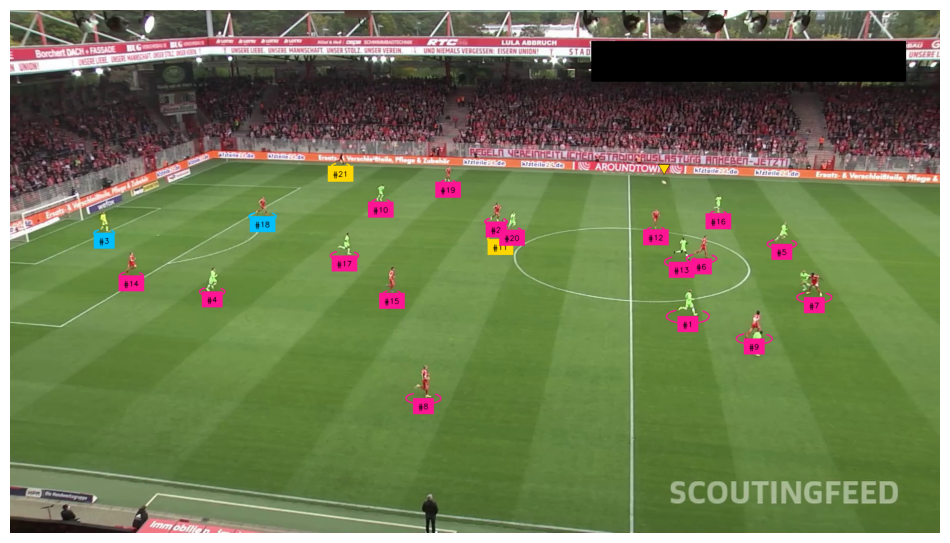

In [7]:
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections.class_id -= 1
all_detections = tracker.update_with_detections(detections=all_detections)

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

In [ ]:
import cv2
import supervision as sv
from tqdm import tqdm
from IPython.display import Video as DisplayVideo  # for displaying the saved video in a notebook

# Define your source video path, output video path, and other constants.
OUTPUT_VIDEO_PATH = "video.mp4"
BALL_ID = 0
# PLAYER_DETECTION_MODEL should be your pre-loaded detection model

# Initialize the annotators
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=2
)

# Initialize and reset the tracker
tracker = sv.ByteTrack()
tracker.reset()

# Create the frame generator from the source video
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# Get the first frame to determine video dimensions
first_frame = next(frame_generator)
height, width = first_frame.shape[:2]
fps = 30  # Set this to the desired frames per second

# Initialize the OpenCV video writer for saving the annotated video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(OUTPUT_VIDEO_PATH, fourcc, fps, (width, height))

def process_frame(frame):
    # Run the detection model on the frame
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    
    # Process detections for ball and players
    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
    
    all_detections = detections[detections.class_id != BALL_ID]
    all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
    all_detections.class_id -= 1
    all_detections = tracker.update_with_detections(detections=all_detections)
    
    # Create labels for the tracked objects
    labels = [f"#{tracker_id}" for tracker_id in all_detections.tracker_id]
    
    # Make a copy of the frame and apply the annotations
    annotated_frame = frame.copy()
    annotated_frame = ellipse_annotator.annotate(scene=annotated_frame, detections=all_detections)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=all_detections, labels=labels)
    annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=ball_detections)
    return annotated_frame

# Process the first frame and write it to the video file
total_frames = fps * 10  # Process 10 seconds of video
annotated_first_frame = process_frame(first_frame)
video_writer.write(annotated_first_frame)

# Using tqdm to show progress for the remaining frames
with tqdm(total=total_frames - 1, desc="Processing frames") as pbar:
    for _ in range(total_frames - 1):
        try:
            frame = next(frame_generator)
        except StopIteration:
            break  # video ended before 10 seconds
        annotated_frame = process_frame(frame)
        video_writer.write(annotated_frame)
        pbar.update(1)

# Finalize the video file
video_writer.release()

Processing frames: 100%|██████████| 299/299 [29:44<00:00,  5.97s/it]


In [9]:
# Display the saved video (works in Jupyter environments)
# display(DisplayVideo(OUTPUT_VIDEO_PATH, embed=True))

embedding extraction: 15it [01:41,  6.78s/it]


In [ ]:
# Note: Here's an interactive visualization of our results. Click on a dot to display its associated crop.

import plotly.graph_objects as go
import numpy as np
from typing import Dict, List
from IPython.core.display import display, HTML
from PIL import Image
import base64
from io import BytesIO


def pil_image_to_data_uri(image: Image.Image) -> str:
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return f"data:image/png;base64,{img_str}"


def display_projections(
    labels: np.ndarray,
    projections: np.ndarray,
    images: List[Image.Image],
    show_legend: bool = False,
    show_markers_with_text: bool = True
) -> None:
    image_data_uris = {f"image_{i}": pil_image_to_data_uri(image) for i, image in enumerate(images)}
    image_ids = np.array([f"image_{i}" for i in range(len(images))])

    unique_labels = np.unique(labels)
    traces = []
    for unique_label in unique_labels:
        mask = labels == unique_label
        customdata_masked = image_ids[mask]
        trace = go.Scatter3d(
            x=projections[mask][:, 0],
            y=projections[mask][:, 1],
            z=projections[mask][:, 2],
            mode='markers+text' if show_markers_with_text else 'markers',
            text=labels[mask],
            customdata=customdata_masked,
            name=str(unique_label),
            marker=dict(size=8),
            hovertemplate="<b>class: %{text}</b><br>image ID: %{customdata}<extra></extra>"
        )
        traces.append(trace)

    fig = go.Figure(data=traces)
    fig.update_layout(
        scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
        width=1000,
        height=1000,
        showlegend=show_legend
    )

    plotly_div = fig.to_html(full_html=False, include_plotlyjs=False, div_id="scatter-plot-3d")

    javascript_code = f"""
    <script>
        function displayImage(imageId) {{
            var imageElement = document.getElementById('image-display');
            var placeholderText = document.getElementById('placeholder-text');
            var imageDataURIs = {image_data_uris};
            imageElement.src = imageDataURIs[imageId];
            imageElement.style.display = 'block';
            placeholderText.style.display = 'none';
        }}

        var chartElement = document.getElementById('scatter-plot-3d');

        chartElement.on('plotly_click', function(data) {{
            var customdata = data.points[0].customdata;
            displayImage(customdata);
        }});
    </script>
    """

    html_template = f"""
    <!DOCTYPE html>
    <html>
        <head>
            <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
            <style>
                #image-container {{
                    position: fixed;
                    top: 0;
                    left: 0;
                    width: 200px;
                    height: 200px;
                    padding: 5px;
                    border: 1px solid #ccc;
                    background-color: white;
                    z-index: 1000;
                    box-sizing: border-box;
                    display: flex;
                    align-items: center;
                    justify-content: center;
                    text-align: center;
                }}
                #image-display {{
                    width: 100%;
                    height: 100%;
                    object-fit: contain;
                }}
            </style>
        </head>
        <body>
            {plotly_div}
            <div id="image-container">
                <img id="image-display" src="" alt="Selected image" style="display: none;" />
                <p id="placeholder-text">Click on a data entry to display an image</p>
            </div>
            {javascript_code}
        </body>
    </html>
    """

    display(HTML(html_template))

display_projections(clusters, projections, crops)

/tmp/ipykernel_2199/933838099.py:6: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display



TraitError: The 'children' trait of a HBox instance contains an Instance of a TypedTuple which expected a Widget, not the Figure Figure({
    'data': [{'customdata': {'bdata': ('AAACAAMACAAKAA0ADgAQABEAEgAVAB' ... 'QBxQHJAcsBzwHRAdQB1QHWAdgB2gE='),
                             'dtype': 'i2'},
              'hovertemplate': '<b>class: %{text}</b><br>index: %{customdata}<extra></extra>',
              'marker': {'size': 8},
              'mode': 'markers+text',
              'name': '0',
              'text': {'bdata': ('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA' ... 'AAAAAAAAAAAAAAAAAAAAAAAAAAAAA='),
                       'dtype': 'f8'},
              'type': 'scatter3d',
              'x': {'bdata': ('Les4QYPJcUFy83xBO4+IQb1LPkGUDI' ... 'H16oBB7z87QX/AT0GzLDlBJZ6DQQ=='),
                    'dtype': 'f4'},
              'y': {'bdata': ('ksx0QAQBOUCxJTRA8N5MQM4MgEADBC' ... 'BMnjNAjDpgQCJDMUDg83JAyd0OQA=='),
                    'dtype': 'f4'},
              'z': {'bdata': ('ckNAQOh6jEDVBpFAYBWhQHbPXEDD96' ... 'DbJ55AQ4VHQC6XdUB34l1ANQ6uQA=='),
                    'dtype': 'f4'}},
             {'customdata': {'bdata': ('AQAEAAUABgAHAAkACwAMAA8AEwAUAB' ... 'HMAc0BzgHQAdIB0wHXAdkB2wHcAQ=='),
                             'dtype': 'i2'},
              'hovertemplate': '<b>class: %{text}</b><br>index: %{customdata}<extra></extra>',
              'marker': {'size': 8},
              'mode': 'markers+text',
              'name': '1',
              'text': {'bdata': ('AAAAAAAA8D8AAAAAAADwPwAAAAAAAP' ... 'AAAPA/AAAAAAAA8D8AAAAAAADwPw=='),
                       'dtype': 'f8'},
              'type': 'scatter3d',
              'x': {'bdata': ('FFsXv5AmFcCwwve/8+h8vwvwZ7+Opk' ... 'LA4AoswMYtM8D07hA/t7KsvtVR3z4='),
                    'dtype': 'f4'},
              'y': {'bdata': ('F4+eQCHWykAHRbtAMLGzQG+RnUANxJ' ... 'RANmPEQPskyUCLvI9AbCCiQKa2nEA='),
                    'dtype': 'f4'},
              'z': {'bdata': ('ugPaQIR/90B5yepAFa76QGaH8UAaju' ... 'hA4BfvQE3a9kA4g95ApMPkQE+m90A='),
                    'dtype': 'f4'}}],
    'layout': {'height': 600,
               'scene': {'xaxis': {'title': {'text': 'X'}},
                         'yaxis': {'title': {'text': 'Y'}},
                         'zaxis': {'title': {'text': 'Z'}}},
               'showlegend': False,
               'template': '...',
               'width': 800}
}).